# Analysis Setup 

In [1]:
from climpred.prediction import compute_perfect_model
from PMMPIESM.predictability import _pseudo_ens_GE
from tqdm import trange
from PMMPIESM.plot import _set_integer_xaxis

import numpy as np
import xarray as xr
import pandas as pd
from climpred.stats import rm_poly
import matplotlib.pyplot as plt
import PMMPIESM as PM
import seaborn as sb
from PMMPIESM.setup import file_origin, yearmonmean
import seaborn as sb
colors = ["dark blue", "faded blue", "steel blue", "faded green", "faded red"]
cmap=sb.xkcd_palette(colors)
import warnings
warnings.simplefilter("ignore")
from climpred.prediction import compute_perfect_model

xesmf import error
check https://xesmf.readthedocs.io/en/latest/installation.html


In [3]:
#### SAVING FIGURES
## the default savefig params can be different from the display params
## e.g., you may want a higher resolution, or to make the figure
## background white
import matplotlib as mpl
import os
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
#savefig.dpi         : figure   ## figure dots per inch or 'figure'
mpl.rcParams['savefig.dpi'] = 300
#savefig.facecolor   : white    ## figure facecolor when saving
#savefig.edgecolor   : white    ## figure edgecolor when saving
#savefig.format      : png      ## png, ps, pdf, svg
mpl.rcParams['savefig.format'] = 'eps'
#savefig.bbox        : standard ## 'tight' or 'standard'.
                                ## 'tight' is incompatible with pipe-based animation
                                ## backends but will workd with temporary file based ones:
                                ## e.g. setting animation.writer to ffmpeg will not work,
                                ## use ffmpeg_file instead
mpl.rcParams['savefig.bbox'] = 'tight'
#savefig.pad_inches  : 0.1      ## Padding to be used when bbox is set to 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.02
#savefig.jpeg_quality: 95       ## when a jpeg is saved, the default quality parameter.
paper_path = '/Users/aaron.spring/PhD_Thesis/My_Paper/ToE_mitigation_detection/'

In [4]:
sb.set_context('talk')

In [5]:
longname_diag=dict()
longname_diag['co2_flx_land'] = 'diag. atm. CO$_{2}$ due to land'
longname_diag['co2_flx_ocean'] = 'diag. atm. CO$_{2}$ due to ocean'

In [6]:
units=dict()
units['combined']='ppm'
units['ocean']='ppm'
units['land']='ppm'
units['tsurf']='$^\circ$C'
units['co2_flux']='PgC/yr'
units['co2_flx_land']='PgC/yr'
units['co2_flx_ocean']='PgC/yr'

longname=dict()
longname['combined']='diag. CO$_{2,atm}$'
longname['land']='diag. CO$_{2,atm}$ due to land'
longname['ocean']='diag. CO$_{2,atm}$ due to ocean'
longname['tsurf']='GMST'
longname['co2_flux']='CO$_2$ flux'
longname['co2_flx_land']='ocean CO$_2$ flux'
longname['co2_flx_ocean']='land CO$_2$ flux'

In [7]:
sig=95
psig=sig/100
lcil=((100-sig)/2)/100
ucil=1-lcil

## Load from file

In [8]:
gmst = xr.open_dataset('GE_GMST_ym.nc').rename({'ens':'initialization','ext':'member','year':'time'})
co2atm_forcing = xr.open_dataset('co2atm.nc').drop('member').rename({'ext':'member','year':'time'})
cf=xr.open_dataset('GE_co2_flux.nc').rename({'member':'initialization','ext':'member','year':'time'})

In [9]:
gmst_cdo = xr.open_dataset('GE_GMST_ym.nc')
gmst_cdo=gmst_cdo.rename({'ens':'member'})

In [11]:
ce = xr.open_dataset('compatible_emissions.nc')

In [261]:
c4mip = xr.open_dataset('CMIP6_C4MIP_ensemble_CO2_co2_flux.nc')

In [10]:
diagnosed = xr.open_dataset('GE_diagnosed_atm_CO2.nc')

#### pre-defined functions

In [13]:
from esmtools.stats import linregress
def linear_detrend(cf,end=2005,start=1850,dim='time'):
    if isinstance(cf,xr.Dataset):
        varl=[]
        for var in cf.data_vars:
            detrended = remove_trend(cf[var],end=end,start=start,dim=dim)
            detrended.name = var
            varl.append(detrended)
        cf_detrended = xr.merge(varl)
    else:
        cf_detrended = remove_trend(cf)
    return cf_detrended

def remove_trend(ds,start=1850,end=2005,dim='time'):
    res = linregress(ds.sel(time=slice(start,end))[dim],ds.sel(time=slice(start,end)))
    lfit=res['intercept']+res['slope']*ds.time
    detrended = (ds - lfit + ds.mean('time'))
    return detrended

## Setting the context
### Evolution of Historical and RCPs

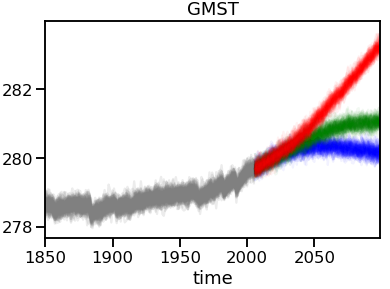

In [14]:
cmape = ['b','g','r']
fig, ax = plt.subplots()
ax.set_title('GMST')
gmst.sel(time=slice(1850,2005)).isel(member=1).to_dataframe().unstack(0)['tsurf'].plot(ax=ax,color='gray',legend=False,alpha=.15)
for i,m in enumerate(gmst.member.values):
    gmst.sel(time=slice(2006,2099)).sel(member=m).to_dataframe().unstack(0)['tsurf'].plot(ax=ax,color=cmape[i],legend=False,alpha=.05)

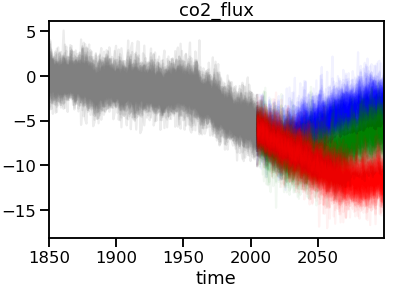

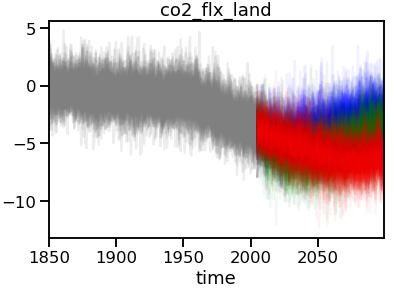

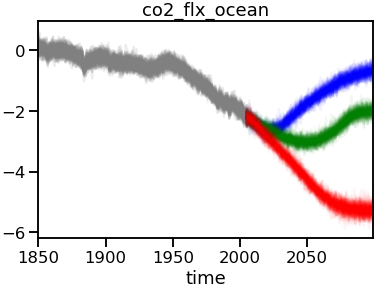

In [15]:
carbon_fluxes=cf.to_dataframe()

all_ext=['rcp26','rcp45','rcp85']
for varname in carbon_fluxes.columns:
    fig, ax = plt.subplots()
    carbon_fluxes[varname].unstack(1)[all_ext[1]].unstack(0).loc[:2005].plot(ax=ax,color='gray',legend=False,alpha=.15)
    for i,ext in enumerate(all_ext):
        carbon_fluxes[varname].unstack(1)[ext].unstack(0).loc[2005:].plot(ax=ax,color=cmape[i],legend=False,alpha=.05)
    ax.set_title(varname)

## atm. CO$_2$ forcing

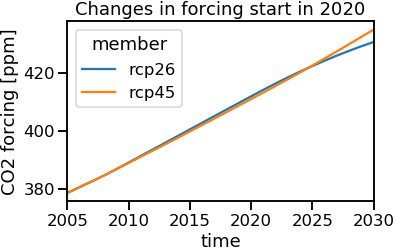

In [18]:
co2atm_forcing.sel(member=['rcp26','rcp45']).sel(time=slice(2005,end)).to_dataframe().unstack(0)['co2atm'].plot(title='Changes in forcing start in 2020')
plt.ylabel('CO2 forcing [ppm]')
plt.tight_layout()
#plt.savefig('co2_forcing')

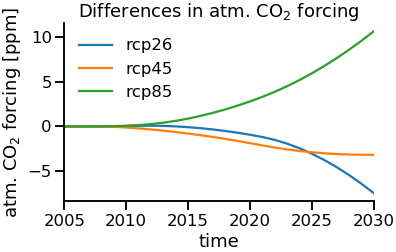

In [19]:
(co2atm_forcing-co2atm_forcing.mean('member')).sel(time=slice(2005,end)).to_dataframe().unstack(0)['co2atm'].plot(title='Differences in atm. CO$_2$ forcing')
plt.ylabel('atm. CO$_2$ forcing [ppm]')
plt.tight_layout()
plt.legend(frameon=False)
sb.despine()
#plt.savefig('co2_forcing_diff2')
plt.show()

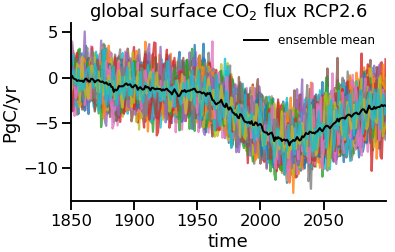

In [20]:
v =' co2_flux'
cf.isel(member=0)[v].to_dataframe().unstack().plot(legend=False,alpha=.8)
m = cf.isel(member=0)[v].mean('initialization').plot(label='ensemble mean',color='k',lw=2,ax=plt.gca())
plt.title('global surface CO$_2$ flux RCP2.6')
plt.ylabel('PgC/yr')
plt.legend(m,['ensemble mean'],fontsize=12, frameon=False)
plt.tight_layout()
sb.despine()
#plt.savefig('co2_flux_evolution')

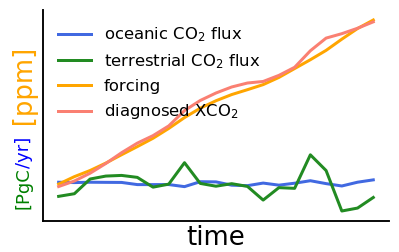

In [393]:
start = 1980
end = 2000
lw = 3
iv = (cf['co2_flx_ocean'] - cf['co2_flx_ocean'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
(iv*2).plot(color='royalblue',lw=lw,label='oceanic CO$_2$ flux')
iv = (cf['co2_flx_land'] - cf['co2_flx_land'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
(iv*2).plot(color='forestgreen',lw=lw, label='terrestrial CO$_2$ flux')
iv = (cf['co2_flux'] - cf['co2_flux'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
f = (co2atm_forcing['co2atm'] - co2atm_forcing['co2atm'].sel(time=start)).isel(member=0).sel(time=slice(start,end))
f.plot(color='orange',lw=lw, label='forcing')
comb=f+iv.cumsum('time')/2.12
comb.plot(color='salmon',lw=lw,label='diagnosed XCO$_2$')
plt.ylabel('       [ppm]',color='orange',fontsize='x-large')
plt.title('')
plt.xlabel('time',fontsize='x-large')
plt.legend(frameon=False)
plt.xticks([], [])
plt.yticks([], [])
x = 0.037
plt.annotate('/yr]',xy=(x, 0.4), 
             xycoords='figure fraction',
             rotation=90,
             fontsize='medium',
             color='blue'
            )
plt.annotate('[PgC',xy=(x, 0.28), 
             xycoords='figure fraction',
             rotation=90,
             fontsize='medium',
             color='green'
            )
plt.tight_layout()
sb.despine()
plt.savefig(paper_path+'FigureSI_diag_atm_CO2_schema')

### Investigating internal variability

In [31]:
#first removing drift with subtracting rolling 50 yr mean
roll = 50
rolld2 = roll//2
cf_internal_variability = cf - cf.rolling(time=roll,center=True).mean().isel(time=slice(rolld2,-rolld2))
cf_internal_variability = cf_internal_variability - cf_internal_variability.mean('initialization')

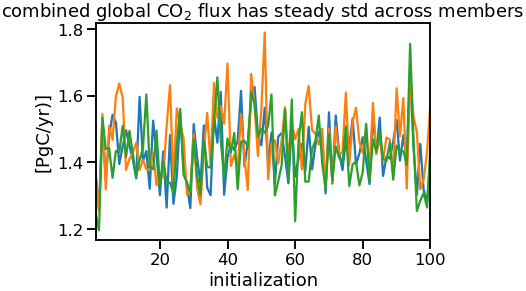

In [32]:
cf_internal_variability.std('time').to_dataframe()['co2_flux'].unstack().plot(legend=False,title='combined global CO$_2$ flux has steady std across members')
plt.ylabel('[PgC/yr)]')
plt.show()

# Diagnosing atmospheric CO$_2$ concentrations
Two methodologies:
- initialize each member inidividually where going through 0
- initialize all

Inventory change in Ocean/Land at the atmospheric surface result in atmospheric CO2 inventory and thereby change atm. CO2 concentration.

As atm. CO2 is prescribed in historical simulations, I diagnose the internal variability of CO$_2$ from the time-accumulated internal variability of the global surface CO$_2$ fluxes. 

Assuming that global CO$_2$ fluxes in PgC=GtC spread in the global atmosphere: 1ppm = 2.12 GtC = 2.12 PgC [Le Quere2018, Doney2006, many others]

Formula:

$pCO_{2,atm,diag}(t) = pCO_{2,atm,forcing}(t) + \sum^t_{t'=1850} \overline{\text{CO$_2$ flux}(t')}\frac{ppm}{2.12PgC}$

The $\overline{\text{overline}}$ denotes zero-mean, zero-trend CO$_2$ flux which is achieved by remove the ensemble member mean and time mean. 

Assumptions:
- atm. CO$_2$ concentrations are driven by emissions and the carbon feedbacks. Inter-annual variability (with the forced signal removed) is due to climate variability only.
- feedback of internal variability of atm. CO$_2$ on CO$_2$ fluxes is negligible:
  - CO$_2$ flux variability is driven by large-scale modes of internal climate variability
  - this assumption also made in CMIP5 historical simulations
- inter-annual variability of atm. CO$_2$ doesn't affect radiation scheme:
  - this assumption is also made in CMIP5 historical simulations

## Diagnose by initializing each member at equil. cum. CO2 flux

In [36]:
fac = 2.13
v='co2_flux'

In [38]:
# initialize every member at its own carbon neutral time in historical (therefore member=0)
flex_inits = cf_internal_variability.isel(member=0).drop('member')[v].sel(time=slice(1850,2005))

Text(0, 0.5, 'PgC/yr')

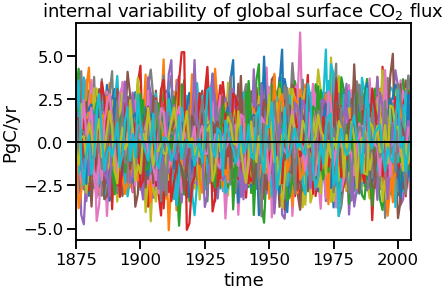

In [39]:
flex_inits.to_dataframe().unstack().plot(legend=False)
flex_inits.mean('initialization').to_dataframe().plot(legend=False,color='k',lw=2,ax=plt.gca())
plt.title('internal variability of global surface CO$_2$ flux')
plt.ylabel('PgC/yr')

In [129]:
# standardize to find close to neutral easier
standardized = (flex_inits-flex_inits.mean('time'))/flex_inits.std('time')
#standardized.to_dataframe().unstack().plot(legend=False)

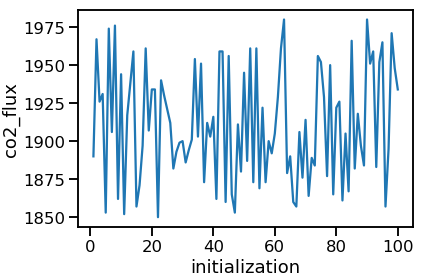

In [43]:
# where every member is close to carbon neutral (defined as less than .1*std away)
(standardized.where(np.abs(standardized)<.1).argmax('time')+1850).plot()

In [70]:
def find_neutral_IC(cf,v='co2_flux',i=1,diff=.1):
    """Find neutral detrended co2_flux cumsum (smaller than diff*std) initial conditions year."""
    # for each member individually
    onem = (cf - cf.mean('initialization')).isel(member=0).isel(initialization=i).sel(time=slice(1850,2005))[v]
    onem = onem - onem.mean('time')
    # aggregate over time
    onemc = (onem).cumsum('time')/2.13
    onemc['time'] = onem.time
    from PMMPIESM.variability import standardize
    onemc_std = standardize(onemc)
    return onemc_std.where(np.abs(onemc_std)<diff).dropna('time').time.values[-1]

In [66]:
neutral_year=dict()
for i in range(0,100):
    res = find_neutral_IC(cf,i=i)
    print(i,res)
    neutral_year[i+1] = res

0 1995
1 1997
2 2004
3 2002
4 2004
5 1999
6 1996
7 2005
8 2002
9 1981
10 2004
11 2000
12 1975
13 2000
14 2005
15 2003
16 2005
17 2001
18 2002
19 2001
20 2001
21 1984
22 2003
23 1975
24 2005
25 2005
26 2000
27 2003
28 1998
29 2004
30 1994
31 2003
32 1995
33 1955
34 2005
35 1984
36 1978
37 2005
38 2002
39 2002
40 2001
41 2000
42 2002
43 2003
44 2004
45 1991
46 1990
47 2005
48 1984
49 1998
50 2004
51 2004
52 1997
53 1981
54 2003
55 1966
56 2004
57 2005
58 2003
59 1994
60 2000
61 2000
62 2005
63 1957
64 2005
65 2003
66 2003
67 1986
68 2003
69 1987
70 2004
71 1994
72 1992
73 1991
74 1996
75 2004
76 2002
77 2005
78 2005
79 1994
80 2005
81 2005
82 2005
83 1999
84 2002
85 2005
86 2005
87 1995
88 2005
89 1992
90 2003
91 1999
92 1997
93 2005
94 2002
95 1974
96 1988
97 2004
98 1996
99 1996


In [67]:
def individual_init(cf_internal_variability,i=90,plot=False):
    """Initialize a member i in its latest carbon neutral year in the historical."""
    end = 2070
    c = cf_internal_variability.sel(initialization=i).isel(member=0)[v]
    if plot:
        c.plot()

    init = (c).sel(time=slice(neutral_year[i]+1,2004)).sum('time')/2.13
    #   member, initialized in 2005 value, neutral year
    print(i, init.values, neutral_year[i])
    # units:        ppm                                          ppm        ppm
    d = co2atm_forcing['co2atm'].sel(time=slice(2005,end)) + init.values + cf_internal_variability.sel(time=slice(2005,end)).sel(initialization=i).cumsum('time')/2.13
    d['time'] = cf_internal_variability.sel(time=slice(2005,end)).time

    if plot:
        d.to_dataframe().unstack(0)[v].plot()
    return d

In [74]:
# initialize every member
res = []
for i in cf_internal_variability.initialization.values:
    res.append(individual_init(cf_internal_variability,i=i))
diagnosed = xr.concat(res,'initialization')
diagnosed['initialization'] = cf_internal_variability.initialization.values

1 0.24404741990514595 1995
2 -3.110839526483232 1997
3 0.0 2004
4 0.984090041602762 2002
5 0.0 2004
6 0.9200250246585585 1999
7 -1.1334142111626242 1996
8 0.0 2005
9 -0.7640674813844542 2002
10 -3.1190478487028663 1981
11 0.0 2004
12 -1.289022083774778 2000
13 1.120819144876233 1975
14 1.0254892002862228 2000
15 0.0 2005
16 -0.3894153519900103 2003
17 0.0 2005
18 -0.45829132734283645 2001
19 0.866626492820856 2002
20 -2.4850746999696263 2001
21 -0.2482901376435326 2001
22 -1.6026943055089753 1984
23 1.2108910585747463 2003
24 -0.8860384494691298 1975
25 0.0 2005
26 0.0 2005
27 -0.7286782600933425 2000
28 -0.5251666669929949 2003
29 0.9571218645300441 1998
30 0.0 2004
31 -1.528951755940444 1994
32 -0.4720886044229237 2003
33 2.6657854445797144 1995
34 0.06466333343193315 1955
35 0.0 2005
36 3.246639786961353 1984
37 1.10327387273546 1978
38 0.0 2005
39 -1.5765319781926326 2002
40 -1.324659094429881 2002
41 0.5250578309677926 2001
42 0.6091920788722668 2000
43 -0.9340250969255298 2002
44

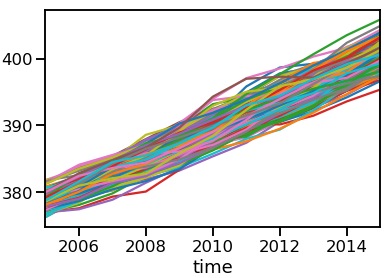

In [381]:
v='co2_flux'
diagnosed.sel(time=slice(2005,2015))[v].to_dataframe().unstack(0).unstack(0)[v].plot(legend=False)

In [79]:
diagnosed_int_var = (diagnosed-co2atm_forcing['co2atm'])

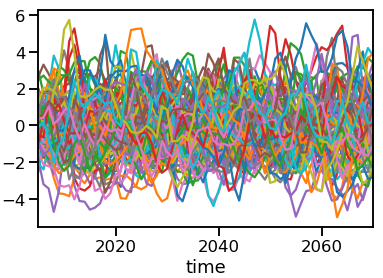

In [80]:
diagnosed_int_var['co2_flux'].isel(member=1).to_dataframe()['co2_flux'].unstack(0).plot(legend=False)

diag. atm. CO$_2$
count             100.00
mean               -0.00
std                 1.09
min                -2.49
25%                -0.80
50%                -0.04
75%                 0.73
max                 2.99

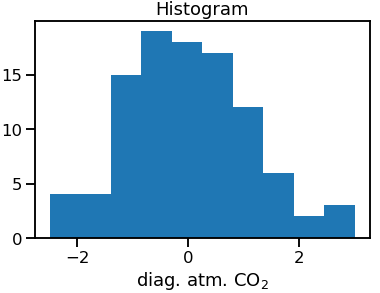

In [82]:
# distribution of diagnosed atm CO2 in 2005
hist = (diagnosed - diagnosed.mean('initialization')).sel(time=slice(2005, 2005)).sel(member=['rcp45'])['co2_flux']
hist.name = 'diag. atm. CO$_2$'
hist.plot.hist()
hist.to_dataframe().describe().round(2)

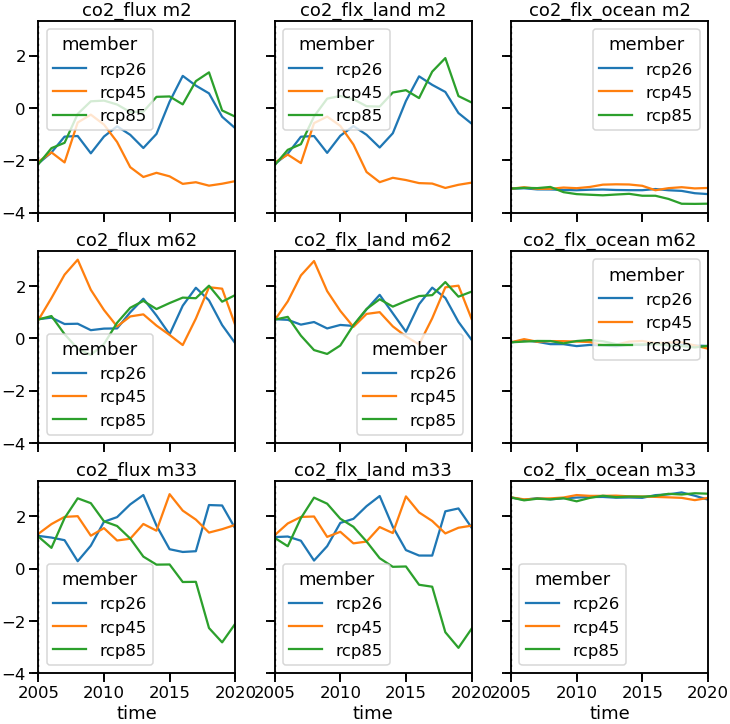

In [83]:
# quick check on individual members
int_var=True
n=3
random_members = np.random.randint(1,100,n)
#varname = 'ocean'
fig,ax=plt.subplots(ncols=3,nrows=n,figsize=(3*4,n*4),sharex=True,sharey=True)
for i,m in enumerate(random_members):
    if int_var:
        t=diagnosed_int_var
    else:
        t=diagnosed
    for j,varname in enumerate(t.data_vars):
        t.sel(initialization=m)[varname].drop('initialization').sel(time=slice(2000,2020)).to_dataframe()[varname].unstack(0).plot(title=' '.join([varname,'m'+str(m)]),ax=ax[i,j])
        ax[i,j].axvline(x=2005,ls=':',c='k')

In [41]:
diagnosed.to_netcdf('GE_diagnosed_atm_CO2.nc')

In [284]:
def diagnose_early_to_2004(cf_internal_variability,diagnosed,i=2,s=1880,e=2005):
    """Diagnose atm. CO$_2$ for historical period initialized with the 2005 values."""
    init = diagnosed.sel(time=2005)['co2_flux'].isel(member=0) - co2atm_forcing['co2atm'].sel(time=2005,member='rcp26').values
    diag_before = co2atm_forcing['co2atm'].sel(time=slice(s,e)) + init + cf_internal_variability.sel(time=slice(s,e)).cumsum('time')/2.13
    diag_before['time'] = cf_internal_variability.sel(time=slice(s,e)).time
    # adjust diag_before to diagnosed
    offset = diagnosed['co2_flux'].isel(member=0).sel(time=2005).squeeze() - diag_before['co2_flux'].isel(member=0).sel(time=2005).squeeze()
    diag_before = diag_before + offset
    return diag_before

diagnosed_all=xr.concat([diagnose_early_to_2004(cf_internal_variability,diagnosed,i=2).sel(time=slice(1880,2004)),diagnosed],'time')

## Diagnose atm. CO$_2$ algorithm all

In [84]:
sig=95
psig=sig/100
lcil=((100-sig)/2)/100
ucil=1-lcil

In [113]:
def get_inits(gmst,psig=psig):
    """Get initializations based on quantile psig."""
    init_gmst=gmst.isel(member=0).sel(time=2005)
    pos_threshold = init_gmst.quantile(1-psig)
    neg_threshold = init_gmst.quantile(psig)
    print(pos_threshold.to_array().values,neg_threshold.to_array().values)
    neg_inits=init_gmst.where(init_gmst<pos_threshold).dropna('initialization').initialization.values
    pos_inits=init_gmst.where(init_gmst>neg_threshold).dropna('initialization').initialization.values
    return pos_inits, neg_inits

In [114]:
def plot_inits(ds,start=2000,end=2015,var='tsurf',pos_inits=None,title=None,ax=None):
    """Plot some inits in color."""
    ds=ds[var].sel(time=slice(start,end))
    if ax is None:
        fig,ax=plt.subplots(figsize=(10,5))
    ax.axvline(x=2005,c='k',ls='--')
    ds.to_dataframe().unstack().unstack()[var].plot(c='gray',alpha=.1,legend=False,ax=ax)

    ds_h = ds.sel(initialization=pos_inits)
    cmap = sb.color_palette('Set2',ds_h.initialization.size)
    for i,init in enumerate(ds_h.initialization.values):
        ds_h.sel(initialization=init).to_dataframe().unstack()[var].plot(c=cmap[i-1],legend=False,ax=ax)
    ax.set_xlim([start,end])
    ax.set_ylabel(var+' ['+units[var]+']')

In [87]:
GtC2ppm = 1/2.13
psig=.8
def diagnose_co2atm_with_forced_co2atm(ds,co2_forcing, detrend_output=True, rm_mean=None, init='',
                                       int_var_only=False,
                                       linear_detrend_results=False,
                                       remove_time_mean=True,
                                       remove_hist_time_mean=False,
                                       remove_forced_signal=False,
                                       remove_50_yr_running_mean=True,
                                       remove_spread_2005=True
                                      ):
    """Diagnose atmospheric co2 from carbon sinks.
    
    Takes internal variability component of carbon sinks ds and co2_forcing.
    Start with the initial value of co2 if available, then convert to ppm and add up contributions."""
    plot=True
    co2_flx_land=ds['co2_flx_land']
    co2_flx_ocean=ds['co2_flx_ocean']

    co2=co2_forcing
    if int_var_only:
        co2=co2.sel(year=2005)
    if rm_mean:
        #co2_flx_ocean = et.stats.xr_rm_trend(co2_flx_ocean)
        co2_flx_ocean = co2_flx_ocean - co2_flx_ocean.mean('time')
        co2_flx_land = co2_flx_land - co2_flx_land.mean('time')
        
    atmco2_ocean = (co2_flx_ocean*GtC2ppm).cumsum('time') + co2
    atmco2_land = (co2_flx_land*GtC2ppm).cumsum('time') + co2
    atmco2_combined = atmco2_land + atmco2_ocean - co2
    atmco2_land = atmco2_land.rename({'co2atm':'land'})
    atmco2_ocean = atmco2_ocean.rename({'co2atm':'ocean'})
    atmco2_combined = atmco2_combined.rename({'co2atm':'combined'})
    diagnosed = xr.merge([atmco2_ocean['ocean'], atmco2_land['land'], atmco2_combined['combined'],co2])
    
    def plot_diagnosed(diagnosed,start=1850,end=2040):
        pos_inits, neg_inits = get_inits(diagnosed,psig=psig)
        print('pos inits',pos_inits)
        plot_inits(diagnosed,pos_inits=pos_inits,var=v,start=start,end=end)
        plt.show()
    
    pos_inits = [1,5,8,60,90]
    if plot:
        print('diagnosed')
        plot_diagnosed(diagnosed)
    if detrend_output:
        print('rm co2 forcing')
        diagnosed_rm_co2 = diagnosed.drop('co2atm') - co2['co2atm']
        if plot:
            plot_diagnosed(diagnosed_rm_co2)
        
        #if linear_detrend_results:
            #print('linear detrend')
            #diagnosed_rm_co2_detrended = linear_detrend(diagnosed_rm_co2)
            #if plot:
            #    plot_diagnosed(diagnosed_rm_co2_detrended)
        
        
        if remove_time_mean:
            #print('remove time mean')
            diagnosed_rm_co2_detrended = diagnosed_rm_co2 - diagnosed_rm_co2.mean('time')
            if plot:
                plot_diagnosed(diagnosed_rm_co2_detrended)
        
        if remove_hist_time_mean:
            print('remove hist 1850-2005')
            diagnosed_rm_co2_detrended = diagnosed_rm_co2_detrended - diagnosed_rm_co2_detrended.sel(time=slice(1850,2005)).mean('time')
            if plot:
                plot_diagnosed(diagnosed_rm_co2_detrended)
        
        #diagnosed_rm_co2_detrended = diagnosed_rm_co2
        if remove_50_yr_running_mean:
            print('50 year running mean')
            diagnosed_rm_co2_detrended = diagnosed_rm_co2_detrended - diagnosed_rm_co2_detrended.rolling(time=50).mean()
            if plot:
                plot_diagnosed(diagnosed_rm_co2_detrended)
                
        if linear_detrend_results:
            print('linear detrend')
            diagnosed_rm_co2_detrended = linear_detrend(diagnosed_rm_co2_detrended,end=2099)
            if plot:
                plot_diagnosed(diagnosed_rm_co2_detrended)
        
        if remove_spread_2005:
            print('remove member spread in 2005')
            diagnosed_rm_co2_detrended = diagnosed_rm_co2_detrended - diagnosed_rm_co2_detrended.sel(time=2005).mean('initialization')
            if plot:
                plot_diagnosed(diagnosed_rm_co2_detrended,start=1995,end=2025)
                plot_diagnosed(diagnosed_rm_co2_detrended)
        
        diagnosed = diagnosed_rm_co2_detrended + co2['co2atm']
        diagnosed = xr.merge([diagnosed,co2])
        
    if plot:
        plot_diagnosed(diagnosed)

    return diagnosed

In [115]:
#diagnosed = diagnose_co2atm_with_forced_co2atm(cf_internal_variability_detrended,co2atm_forcing,int_var_only=False)

# Verification of diagnosed

## Figure 1

In [116]:
import PMMPIESM
# donwload data
GM=PMMPIESM.load.CO2_global_mean().groupby('time.year').mean('time').rename({'year':'time'})
GMGR = GM.diff('time').to_dataframe('GM')
MLO=PMMPIESM.load.CO2_Mauna_Loa().groupby('time.year').mean('time').rename({'year':'time'})
MLOGR=MLO.sel(time=slice('1980',None)).diff('time').to_dataframe('MLO')

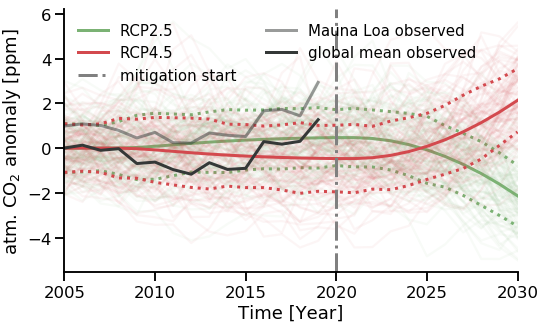

In [416]:
colors = ["faded green", "faded red", "charcoal"]
cmap=sb.xkcd_palette(colors)

end=2030
forcing = 0
forcing = diagnosed['co2_flux'].sel(time=slice(2005,end)).isel(member=[0,1]).mean('member').mean('initialization')
fig,ax=plt.subplots(figsize=(8,5))
handles=[]
for i in range(2):
    (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).to_dataframe()['co2_flux'].unstack(0).plot(ax=ax,alpha=.05, c=cmap[i],legend=False)
    mean = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).mean('initialization')
    std = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).std('initialization')
    m,=mean.plot(c=cmap[i],lw=3)
    handles.append(m)
    (mean+std).plot(c=cmap[i],lw=3,ls=':')
    (mean-std).plot(c=cmap[i],lw=3,ls=':')
ms=ax.axvline(x=2020,ls='-.',lw=3,c='gray')

#obs
gmo,=(GM-forcing).plot(c=cmap[2],lw=3)
mlo,=(MLO-forcing).plot(c=cmap[2],lw=3,alpha=.5)

ax.legend(handles+[ms,mlo,gmo],['RCP2.5','RCP4.5','mitigation start','Mauna Loa observed','global mean observed'],
          frameon=False,ncol=2, fontsize='small')
sb.despine()
plt.ylabel('atm. CO$_2$ anomaly [ppm]')
plt.xlabel('Time [Year]')
plt.tight_layout()
plt.savefig(paper_path+'Figure1_co2_forcing_diff.png')

## Figure SI1

In [259]:
def diagnose_emission_driven(ds):
    co2_flux = ds['co2_flux']
    co2_flux = co2_flux-co2_flux.mean('member')
    non_zero_comp = co2_flux.sel(time=slice('1850','1870')).mean(['time','member'])
    #print(non_zero_comp)
    co2_flux = co2_flux - non_zero_comp
    diag = co2_flux.cumsum('time')/2.12
    ds['diagnosed'] = diag + ds['CO2'].mean('member')
    return ds

In [262]:
d=yearmonmean(diagnose_emission_driven(c4mip)['diagnosed'])

In [263]:
c4mip_ym = yearmonmean(c4mip)

In [266]:
forcing=c4mip_ym['CO2'].mean('member')
#forcing=0

member 1 ACC 0.997 RMSE 0.152 MAE 0.134
member 2 ACC 0.998 RMSE 0.091 MAE 0.076
member 3 ACC 0.989 RMSE 0.167 MAE 0.139
member 4 ACC 0.992 RMSE 0.130 MAE 0.109
member 5 ACC 0.994 RMSE 0.142 MAE 0.129
member 6 ACC 0.993 RMSE 0.146 MAE 0.118
member 7 ACC 0.991 RMSE 0.137 MAE 0.113
member 8 ACC 0.995 RMSE 0.165 MAE 0.147
member 9 ACC 0.995 RMSE 0.224 MAE 0.207


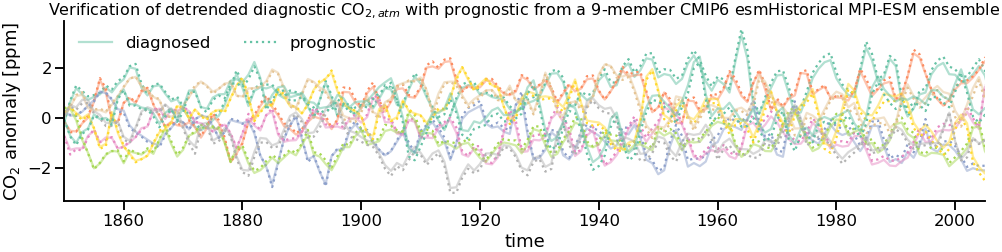

In [267]:
import xskillscore as xs
r_mae=[]
r_rmse=[]
r_pearson_r=[]
cmap = sb.color_palette('Set2',c4mip.member.size)
fig,ax=plt.subplots(figsize=(15,4))
for i,m in enumerate(d.member):
    #print(m.values)
    a=d.sel(member=m)-forcing
    p1=a.plot(label='diagnosed',c=cmap[i],alpha=.5)
    b=c4mip_ym.sel(member=m)['CO2']-forcing
    b=b-b.isel(time=0)+a.isel(time=0)
    p2=b.plot(label='prognostic',c=cmap[i],ls=':')
    plt.title(int(m.values))
    r=xs.mae(a,b,'time')
    #print(f"mae {r.values:.3f}")
    r_mae.append(r)
    r=xs.rmse(a,b,'time')
    #print(f"rmse {r.values:.3f}")
    r_rmse.append(r)
    r=xs.pearson_r(a,b,'time')
    print(f"member {int(m)} ACC {r.values:.3f} RMSE {r_rmse[-1].values:.3f} MAE {r_mae[-1].values:.3f}")
    r_pearson_r.append(r)
plt.ylabel('CO$_2$ anomaly [ppm]')
plt.title('Verification of detrended diagnostic CO$_{2,atm}$ with prognostic from a '+str(int(c4mip_ym.member.size))+'-member CMIP6 esmHistorical MPI-ESM ensemble',fontsize=16)
plt.legend()
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=2, frameon=False)
plt.xlim([1850,2005])
sb.despine()
plt.tight_layout()
plt.savefig(paper_path+'FigureSI_Verification_diagnosed')

In [268]:
r_mae = xr.concat(r_mae,'member')
r_rmse = xr.concat(r_rmse,'member')
r_pearson_r = xr.concat(r_pearson_r,'member')

df=xr.concat([r_mae,r_rmse,r_pearson_r],'metric')
df['metric']=['MAE','RMSE','ACC']
df=df.to_dataframe('res').unstack(0)

df.describe().round(3)

res              
metric    ACC    MAE   RMSE
count   9.000  9.000  9.000
mean    0.994  0.130  0.150
std     0.003  0.036  0.035
min     0.989  0.076  0.091
25%     0.992  0.113  0.137
50%     0.994  0.129  0.146
75%     0.995  0.139  0.165
max     0.998  0.207  0.224

In [269]:
# difference of each member towards anomaly
c=(c4mip_ym-c4mip_ym.mean('member'))['CO2']
c.to_dataframe().unstack().describe().round(2)

CO2                                                                
member       1       2       3       4       5       6       7       8       9
count   165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00
mean      0.56    0.34    0.00   -0.40   -0.07   -0.18   -0.09   -0.52    0.37
std       0.76    0.82    0.76    0.66    0.55    0.87    0.64    0.77    0.79
min      -1.20   -2.33   -2.06   -1.76   -1.30   -2.75   -1.51   -2.57   -1.84
25%       0.09   -0.24   -0.56   -0.84   -0.45   -0.69   -0.57   -1.07   -0.09
50%       0.54    0.45    0.11   -0.37   -0.12   -0.13   -0.08   -0.58    0.40
75%       1.14    0.93    0.57    0.04    0.33    0.37    0.41    0.01    0.91
max       2.82    2.16    1.75    1.74    1.35    1.78    1.45    1.13    2.45

# Climate index regressions

In [274]:
nino_region='34'
v='nino'+nino_region
enso = f'/Users/aaron.spring/mistral_m300524/post/mpiom/161103_ENSO/output/lkm0???_sst_anomaly_standardized_1855_2005_{nino_region}.nc'

In [357]:
e = xr.open_mfdataset(enso,concat_dim='member').rename({'sst':v})[v].squeeze().compute()
del e['lon']
del e['lat']
del e['depth']

In [358]:
e['member']=np.arange(1,101)

In [359]:
e=yearmonmean(e)

In [360]:
#e.to_dataframe().unstack(0).plot(legend=False)

In [361]:
field = diagnosed_all.isel(member=0,drop=True).rename({'initialization':'member'})
field = field-field.mean('member')

In [362]:
lag = 1
e = e.sel(time=slice(field.time.min(),field.time.max()-lag))
field = field.sel(time=slice(e.time.min()+lag,e.time.max()+lag))
e['time']=field.time.values

<xarray.DataArray 'time' (time: 126)>
array([1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
       1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903,
       1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005])
Coordinates:
  * time     (time) int64 1880 1881 1882 1883 1884 ... 2001 2002 2003 2004 2005
<xarray.DataArray 'time' (time: 126

In [363]:
from esm_analysis.composite import composite_analysis

In [368]:
comp = xr.concat([composite_analysis(field.sel(member=i),e.sel(member=i),threshold=1.5) for i in e.member],'member')

In [369]:
comp['co2_flux'].to_dataframe().unstack().describe()#.plot()

co2_flux            
index    negative    positive
count  100.000000  100.000000
mean    -0.718210    1.267276
std      0.364488    0.347355
min     -1.608533    0.609235
25%     -0.906296    0.974542
50%     -0.724917    1.275496
75%     -0.513866    1.527695
max      0.520015    2.063419

In [177]:
3.94/2.12

1.8584905660377358

In [178]:
3.2/2.12

1.509433962264151

In [370]:
# strong El Nino
comp.mean('member')

<xarray.Dataset>
Dimensions:        (index: 2)
Coordinates:
  * index          (index) <U8 'positive' 'negative'
Data variables:
    co2_flux       (index) float64 1.267 -0.7182
    co2_flx_land   (index) float64 1.284 -0.7296
    co2_flx_ocean  (index) float64 -0.01174 0.01144

In [371]:
comp.std('member')

<xarray.Dataset>
Dimensions:        (index: 2)
Coordinates:
  * index          (index) <U8 'positive' 'negative'
Data variables:
    co2_flux       (index) float64 0.3456 0.3627
    co2_flx_land   (index) float64 0.3533 0.3692
    co2_flx_ocean  (index) float64 0.1336 0.07158

# Difference between global atm CO2 and co2_flux
## Lag1 autocorrelation of annual means detrended by the forced signal

In [428]:
def _shift(a, b, lag, dim='time'):
    """
    Helper function to return two shifted time series for applying statistics
    to lags. This shifts them, and then forces them to have a common dimension
    so as not to break the metric functions.
    This function is usually applied in a loop. So, one loops over (1, nlags)
    applying the shift, then the metric, then concatenates all results into
    one xarray object.
    """
    if a[dim].size != b[dim].size:
        raise IOError('Please provide time series of equal lengths.')
    N = a[dim].size
    a = a.isel({dim: slice(0, N - lag)})
    b = b.isel({dim: slice(0 + lag, N)})
    b[dim] = a[dim]
    return a, b

from xskillscore import pearson_r
def compute_persistence(reference, nlags, metric=pearson_r,dim='time'):
    plag = []  # holds results of persistence for each lag
    for i in range(1, 1 + nlags):
        a, b = _shift(reference, reference, i, dim=dim)
        plag.append(metric(a, b, dim=dim))
    pers = xr.concat(plag, 'time')
    pers['time'] = np.arange(1, 1 + nlags)
    return pers    

In [429]:
diagnosed3 = diagnosed.rename(
    {'co2_flux':'combined','co2_flx_ocean':'ocean','co2_flx_land':'land'}).transpose()

In [439]:
t=xr.merge([cf_internal_variability_detrended.isel(member=0).drop('member'),
            (diagnosed3-diagnosed3.mean('initialization')).isel(member=0).drop('member'),
            (gmst-gmst.mean('initialization')).isel(member=0).drop('member')])

co2_flux
co2_flx_land
co2_flx_ocean
combined
land
ocean
tsurf


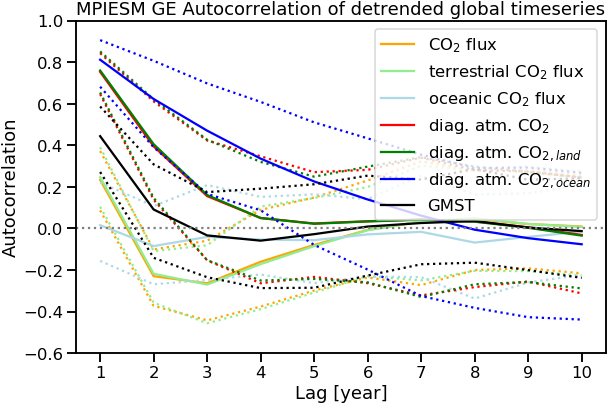

In [485]:
mpl.rcParams['font.size'] = 14

cmap = sb.color_palette(['orange','lightgreen','lightblue','red','green','blue','black'])
fig,ax=plt.subplots(figsize=(9,6))
psig=.95
eps=True
s=[]
for i,v in enumerate(t.data_vars):
    print(v)
    pers=compute_persistence(t.dropna('time'),nlags=10)[v]
    p,=pers.mean('initialization').plot(label=v,ax=ax,color=cmap[i])
    s.append(p)
    if not eps:
        ax.fill_between(pers.time,pers.quantile(psig,'initialization'),pers.quantile(1-psig,'initialization'),alpha=.05,color=cmap[i])
    else:
        pers.time,pers.quantile(psig,'initialization').plot(color=cmap[i],ls=':',label=False)
        pers.time,pers.quantile(1-psig,'initialization').plot(color=cmap[i],ls=':',label=False)
plt.legend(s,['CO$_2$ flux','terrestrial CO$_2$ flux','oceanic CO$_2$ flux',
            'diag. atm. CO$_{2}$','diag. atm. CO$_{2,land}$','diag. atm. CO$_{2,ocean}$','GMST'])
plt.title('MPIESM GE Autocorrelation of detrended global timeseries')
plt.ylabel('Autocorrelation')
plt.xlabel('Lag [year]')
plt.ylim([-.6,1])
plt.axhline(y=0,ls=':',c='gray')
plt.xticks(np.arange(1,11))
plt.tight_layout()
plt.savefig(paper_path+'FigureSI_ACF_modelled')
plt.show()

## Comparison ACF observations and model
see different notebook

# Trend mitigation probabilities [Marotzke 2019]
Event: climate response = decrease in iconic climate variable over 2021-2035 compared to 2006-2020

In [89]:
def linear_trend(df):
    return df.apply(lambda g: np.polyfit(g.index,g, 1))

def create_trends(ds, start=2006,end=2035,print_res=False,**kwargs):
    mid = int((end-start+1)/2+start)-1
    trendlength=int((end-start+1)/2)
    if print_res:
        print('Trends',start,'-',mid,mid+1,'-',end, 'Trendlength:', trendlength)
    df = ds.sel(year=slice(start,end)).to_dataframe().unstack(0).unstack(0)
    # define early and late trends
    early = df.loc[start:mid]
    late = df.loc[mid+1:end]
    trend_late = linear_trend(late).loc[0].unstack().T
    trend_early = linear_trend(early).loc[0].unstack().T
    return trend_late, trend_early, trendlength
    
def mitigation_probability(trend_late, trend_early, event='weaker_trend', trendlength=15, print_res=True, output=False):
    # whats a successful climate mitigation event?
    if event=='stronger_trend':
        event = trend_late - trend_early
    elif event=='weaker_trend':
        event = trend_early - trend_late
    else:
        raise ValueError('not impl')
    if print_res:
        print('\n events \n',round((trendlength*event).head(),2))
    event_summary=(event>0).sum().unstack()/100
    if print_res:
        print('\n event summary\n',event_summary)
    P_RCP26 = event_summary['rcp26']
    P_RCP45 = event_summary['rcp45']
    P_S = (P_RCP26 - P_RCP45) / (1 - P_RCP45)
    if print_res:
        print('\nP_S =\n',round(P_S,2))
    P_N = 1 - (P_RCP45 / P_RCP26)
    if print_res:
        print('\nP_N =\n',round(P_N,2))
    P_NS = P_RCP26 - P_RCP45
    if print_res:
        print('\nP_NS =\n',round(P_NS,2))
    if output:
        return P_S, P_N, P_NS, P_RCP26, P_RCP45

## Mitigation causes reduced trend probabilities atm. CO$_2$

Definitions:

- $P_{RCP2.6}$: Probability of trend reduction in GMST in scenario RCP2.6
- $P_{RCP4.5}$: Probability of trend reduction in GMST in scenario RCP4.5
- $P_S$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient causation sense
- $P_N$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a necessary causation sense
- $P_{NS}$: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient and necessary causation sense

In [90]:
def Marotzke_2019(ds,start=2006,end=2035,combined=False,**kwargs):
    trend_late, trend_early, trendlength=create_trends(ds,start=start,end=end,**kwargs)
    P_S, P_N, P_NS, P_RCP26, P_RCP45 = mitigation_probability(trend_late, trend_early, trendlength=trendlength,**kwargs)
    if combined:
        ds_new = xr.Dataset()
        ds_new['P_S'] = P_S
        ds_new['P_N'] = P_N
        ds_new['P_NS'] = P_NS
        ds_new['P_RCP26'] = P_RCP26
        ds_new['P_RCP45'] = P_RCP45
        ds_new = ds_new.to_array('P').squeeze()
        ds_new.name = 'tsurf'
        del ds_new['dim_0']
        return ds_new
    else:
        return trend_late, trend_early, trendlength, P_S, P_N, P_NS, P_RCP26, P_RCP45

In [91]:
#Marotzke_2019(gmst_cdo,end=2035,combined=True,print_res=True,output=True)

In [92]:
def plot_Marotzke_2019_Box_plots(ds,start=2006,end=2035):
    mid = int((end-start+1)/2+start)-1
    trendlength=int((end-start+1)/2)
    diff_rcp = (ds.sel(ext='rcp45')-ds.sel(ext='rcp26')).sel(year=slice(start,end))
    rcp45=ds.sel(ext='rcp45').sel(year=slice(start,end))
    rcp26=ds.sel(ext='rcp26').sel(year=slice(start,end))
    nplots=len(ds.data_vars)
    fig, ax = plt.subplots(nplots,figsize=(6,nplots*4),squeeze=True)
    for i,varname in enumerate(ds.data_vars):
        if nplots==1:
            tax=ax
        else:
            tax=ax[i]
        diff_rcp.to_dataframe()[varname].unstack(0).plot(legend=False,alpha=.5,ax=tax)
        mean = diff_rcp.mean('member')[varname]
        std = diff_rcp.std('member')[varname]
        mean.plot(c='k',lw=3,ax=tax)
        (mean+std).plot(c='k',lw=2,ls=':',ax=tax)
        (mean-std).plot(c='k',lw=2,ls=':',ax=tax)
        tax.axhline(y=0,c='k')
        tax.set_xlim(start,end)
        #plt.title('Fig B1: Differences between the scenarios RCP4.5 and RCP2.6 in ',varname,' here, as simulated by the MPI-GE over the period',start,'-','end.\n
        #The differences are coherent in the sense that each pair of simulations starts from the identical state at the end of the historical simulation (end of 2005)')
        tax.set_title('RCP4.5 - RCP2.6: '+varname)
    fig.tight_layout()
    (diff_rcp.var('member')/diff_rcp.var('member').isel(year=-1)).to_dataframe().plot()
    plt.axhline(y=.9,c='gray',ls='-.')
    plt.title('Normalized ensemble variance')

In [93]:
#plot_Marotzke_2019_Box_plots(gmst_cdo)

In [94]:
def plot_Marotzke_2019_timeseries(ds,start=2006,end=2035):
    mid = int((end-start+1)/2+start)-1
    trendlength=int((end-start+1)/2)
    diff_rcp = (ds.sel(ext='rcp45')-ds.sel(ext='rcp26')).sel(year=slice(start,end))
    rcp45=ds.sel(ext='rcp45').sel(year=slice(start,end))
    rcp26=ds.sel(ext='rcp26').sel(year=slice(start,end))
    nplots=len(ds.data_vars)
    fig, ax = plt.subplots(nrows=2,ncols=nplots,figsize=(6*nplots,nplots*4),squeeze=False,sharex=True,sharey=True)
    for i,varname in enumerate(ds.data_vars):
        rcp26.to_dataframe()[varname].unstack(0).plot(ax=ax[0,i],legend=False,label='')
        rcp26.mean('member').to_dataframe()[varname].plot(label='RCP2.6 ensemble mean',ax=ax[0,i],c='b',lw=3)
        rcp45.mean('member').to_dataframe()[varname].plot(label='RCP4.5 ensemble mean',ax=ax[0,i],c='r',lw=3)
        ax[0,i].axvline(x=mid+.5,ls=':',color='k')
        ax[0,i].set_title('RCP2.6 '+varname)
        #ax[0,i].legend()
        rcp45.to_dataframe()[varname].unstack(0).plot(ax=ax[1,i],legend=False,label='')
        rcp26.mean('member').to_dataframe()[varname].plot(label='RCP2.6 ensemble mean',ax=ax[1,i],c='b',lw=3)
        rcp45.mean('member').to_dataframe()[varname].plot(label='RCP4.5 ensemble mean',ax=ax[1,i],c='r',lw=3)
        ax[1,i].axvline(x=mid+.5,ls=':',color='k')
        ax[1,i].set_title('RCP4.5 '+varname)
        #ax[1,i].legend()
        ax[0,i].set_xlim([start,end])
        ax[1,i].set_xlim([start,end])
    fig.tight_layout()
    
def plot_Marotzke_2019_timeseries_int_var_only(ds,start=2006,end=2035):
    mid = int((end-start+1)/2+start)-1
    trendlength=int((end-start+1)/2)
    #diff_rcp = (ds.sel(ext='rcp45')-ds.sel(ext='rcp26')).sel(year=slice(start,end))
    rcp45=ds.sel(ext='rcp45').sel(year=slice(start,end))
    rcp26=ds.sel(ext='rcp26').sel(year=slice(start,end))
    nplots=len(ds.data_vars)
    fig, ax = plt.subplots(nrows=2,ncols=nplots,figsize=(6*nplots,nplots*4),squeeze=False,sharex=True,sharey=True)
    for i,varname in enumerate(ds.data_vars):
        (rcp26-rcp26.mean('member')).to_dataframe()[varname].unstack(0).plot(ax=ax[0,i],legend=False,label='')
        ax[0,i].axvline(x=mid+.5,ls=':',color='k')
        ax[0,i].set_title('RCP2.6 '+varname)
        (rcp45-rcp45.mean('member')).to_dataframe()[varname].unstack(0).plot(ax=ax[1,i],legend=False,label='')
        ax[1,i].axvline(x=mid+.5,ls=':',color='k')
        ax[1,i].set_title('RCP4.5 '+varname)
        ax[0,i].set_xlim([start,end])
        ax[1,i].set_xlim([start,end])
    fig.tight_layout()

In [20]:
#plot_Marotzke_2019_timeseries(gmst_cdo)

In [21]:
#plot_Marotzke_2019_timeseries(cf)

In [95]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
def add_label(axis,label_index, labelsize):
    labels='abcdefghijk'
    axis.add_artist(AnchoredText(f'({labels[label_index]})', prop=dict(size=labelsize),
                               frameon=False, loc=2, pad=.1, borderpad=.2))
    return axis

In [96]:
xlabelfontsize='medium'
titlefontsize='small'
frameon=False
def plot_Marotzke_2019_frequencies(ds,start=2006,end=2035,nbins=20,unit='',decade=False, obs=None, obs_label=None,
                                   plot_shaded=True, loc='best', **kwargs):
    trend_late, trend_early, trendlength = create_trends(ds, start=start,end=end)
    mid = int((end-start+1)/2+start)-1
    nplots=len(ds.data_vars)
    fig, ax = plt.subplots(2*nplots,3,squeeze=False,sharey=True,figsize=(12,nplots*6),**kwargs)
    alpha=1
    c=sb.xkcd_palette(['faded green','faded red'])
    if decade:
        trendlength=10
    for j,varname in enumerate(ds.data_vars):
        for i,ext in enumerate(['rcp26','rcp45']):
            (trendlength*trend_early)[varname][ext].hist(ax=ax[i+j*2,0],alpha=alpha,bins=nbins,color=c[i])
            ax[0,0].set_title('trend '+str(start)+'-'+str(mid),fontdict={'fontsize':titlefontsize})
            (trendlength*trend_late)[varname][ext].hist(ax=ax[i+j*2,1],alpha=alpha,bins=nbins,color=c[i])
            if plot_shaded:
                (trendlength*trend_early)[varname][ext].hist(ax=ax[i+j*2,1],alpha=alpha,bins=nbins,color='gray',histtype='step')
            ax[0,1].set_title('trend '+str(mid+1)+'-'+str(end),fontdict={'fontsize':titlefontsize})
            (trendlength*(trend_early-trend_late))[varname][ext].hist(ax=ax[i+j*2,2],alpha=alpha,bins=nbins,color=c[i])
            ax[0,2].set_title('trend reduction after mitigation',fontdict={'fontsize':titlefontsize})
            ax[1,2].set_title('trend reduction without mitigation',fontdict={'fontsize':titlefontsize})
            ax[i+j*2,0].axvline(x=0,ls=':',color='k')
            ax[i+j*2,1].axvline(x=0,ls=':',color='k',label='zero trend')
            ax[i+j*2,2].axvline(x=0,ls=':',color='k')
            for k in range(3):
                ax[1,k].set_xlabel(f'[{unit}/{trendlength}yrs]',fontdict={'fontsize':xlabelfontsize})
            # plot mean trend
            ax[i+j*2,0].axvline(x=trend_early.mean(axis=0)[i]*trendlength,c='gray',ls='-.')
            ax[i+j*2,1].axvline(x=trend_late.mean(axis=0)[i]*trendlength,c='gray',ls='-.',label='mean trend')
            ax[i+j*2,2].axvline(x=(trend_early.mean(axis=0)[i]-trend_late.mean(axis=0)[i])*trendlength,c='gray', ls='-.')
            ax[i,0].grid(False)
            ax[i,1].grid(False)
            ax[i,2].grid(False)
            # print P_RCPx
            # number of clim responses
            ncr = float(len([i for i in trendlength*(trend_early-trend_late)[varname][ext]>0 if i])/100)
            ext=ext[:4]+'.'+ext[-1]
            ax[i,2].annotate('P$_{'+ext.upper()+'}$='+str("%.2f" % ncr),xy=(1.1, .45),
                             xycoords='axes fraction',horizontalalignment='right',
                             fontsize='small',#fontname='Helvetica'
                             family='serif')
    
    if obs is not None:
        ax[0,0].axvline(obs,c='k',label=obs_label)
        ax[1,0].axvline(obs,c='k',label=obs_label)
        ax[0,0].legend(fontsize='x-small',frameon=frameon, loc=loc)
    # labeling
    for i in range(2):
        for k in range(3):
            ax[i,k] = add_label(ax[i,k],i*3+k,'small')
    ax[0,0].set_ylabel('RCP2.6 members')
    ax[1,0].set_ylabel('RCP4.5 members')
    ax[1,1].legend(fontsize='x-small',frameon=frameon, loc=loc)
    fig.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle(varname)
    sb.despine(fig)
    return ax

In [97]:
#plot_Marotzke_2019_frequencies(gmst_cdo.rename({'tsurf':'GMST'}),sharex=True,unit='K')#,obs=obs_trend,obs_label='observed 2004-2018')
#plt.show()

In [98]:
from tqdm import trange
def bootstrapping(ds,func,dim='member',bootstrap=5, replacement=True, **func_kwargs):
    bootstraped_results = []
    dim_to_shuffle = ds[dim].values
    length = len(dim_to_shuffle)//2
    for _ in trange(bootstrap):
        if replacement:
            smp_dim = np.random.choice(dim_to_shuffle, len(dim_to_shuffle))
        else:
            dim_to_shuffle = ds[dim].values
            smp_dim = np.random.choice(dim_to_shuffle, replace=False, size=length)
            dim_to_shuffle = ds[dim].isel({dim:slice(None,length)}).values
        smp_ds = ds.sel({dim:smp_dim})
        smp_ds[dim] = dim_to_shuffle
        b_res=func(smp_ds, **func_kwargs)
        bootstraped_results.append(b_res)
    res = xr.concat(bootstraped_results, 'bootstrap')#.quantile( sig / 100, 'bootstrap')
    return res

In [99]:
mid=2021
lower_end=1996
diff2006=mid-lower_end
mintrend=5
for trendlength in range(mintrend,diff2006+1):
    start = mid-trendlength
    end = mid + trendlength - 1
    print(start,mid,end,trendlength)

2016 2021 2025 5
2015 2021 2026 6
2014 2021 2027 7
2013 2021 2028 8
2012 2021 2029 9
2011 2021 2030 10
2010 2021 2031 11
2009 2021 2032 12
2008 2021 2033 13
2007 2021 2034 14
2006 2021 2035 15
2005 2021 2036 16
2004 2021 2037 17
2003 2021 2038 18
2002 2021 2039 19
2001 2021 2040 20
2000 2021 2041 21
1999 2021 2042 22
1998 2021 2043 23
1997 2021 2044 24
1996 2021 2045 25


In [100]:
def over_trendlength(gmst_cdo,bootstrap=500,varname='tsurf',mid=2021,mintrend=5,lower_end=2006,**kwargs):
    ltrendlength=[]
    lres=[]
    #set 2015 as fixed middle
    #mid=2021
    diff2006=mid-lower_end
    for trendlength in range(mintrend,diff2006+1):
        ltrendlength.append(trendlength)
        start = mid-trendlength
        end = mid + trendlength - 1
        print(start,mid,end,trendlength)
        res = bootstrapping(gmst_cdo,Marotzke_2019,print_res=False,start=start,end=end,output=True,combined=True,bootstrap=bootstrap,**kwargs)
        lres.append(res)
    P_gmst=xr.concat(lres,'trendlength')
    P_gmst['trendlength']=ltrendlength
    return P_gmst

In [101]:
def plot_P(P,title='GMST',v='tsurf',ax=None, loc='best',causation=True):
    P = P.where(P >= 0, other=0) 
    print(((P.median('bootstrap')>.95).argmax('trendlength')+3).to_dataframe('TDM'),'ignore P_RCP45 value')
    P['P'] = ['$P_S$', '$P_N$', '$P_{NS}$', '$P_{RCP2.6}$', '$P_{RCP4.5}$']
    if ax is None:
        fig,ax=plt.subplots(figsize=(8,5))
    colors = ["steel blue", "medium blue", "dark blue", "faded green", "faded red"]
    cmap=sb.xkcd_palette(colors)
    fac=100
    mean = P.median('bootstrap')*fac
    ul = P.quantile(psig,'bootstrap')*fac
    ll = P.quantile(1-psig,'bootstrap')*fac
    res_Marotzke2019=[.40,.33,.22,.67,.45]
    df=mean.to_dataframe()[v].unstack()
    
    for i,iP in enumerate(P.P.values):
        yerr = [ll.to_dataframe()[v].unstack()[iP]-df[iP],df[iP]-ul.to_dataframe()[v].unstack()[iP]]
        if causation:
            df[iP].plot(yerr=yerr,capsize=4,c=cmap[i],marker='o')
        else:
            if iP in ['$P_{RCP2.6}$', '$P_{RCP4.5}$']:
                df[iP].plot(yerr=yerr,capsize=4,c=cmap[i],marker='o')
    ax=plt.gca()
    ax.set_title(title)
    ax.set_ylim([-5,105])
    ax.set_ylabel('Probability P [%]')
    ax.set_xlabel('Trend length [years]')
    #ax.axhline(y=50,c='gray',label='')
    ax.set_xlim([df.index.min()-1,df.index.max()+1])
    ax.set_xticks(np.arange(df.index.min(),df.index.max()+1))
    if causation:
        ncol = 2
        legendtitle = 'Causation: Trend reduction:'
    else:
        ncol = 1
        legendtitle = 'Trend reduction:'
    ax.legend(ncol=ncol, fontsize='small', frameon=False, loc=loc,
              title=legendtitle, title_fontsize='x-small',
              labelspacing=.3, columnspacing=.5)
    if title is 'GMST':
            for i,p in enumerate(P_gmst.P):
                plt.scatter(15,100*res_Marotzke2019[i],marker='x',color=cmap[i])
    ax.axhline(y=95,color='gray',ls=':')
    ax.axhline(y=5,color='gray',ls=':')
    plt.tight_layout()

In [102]:
#plot_P(P_co2_combined.sel(trendlength=slice(3,15)),title='Diagnosed global atmospheric CO$_2$',causation=False)
#plot_P(P_gmst.sel(trendlength=slice(3,15)),title='Diagnosed global atmospheric CO$_2$',causation=True)

In [103]:
def plot_Marotzke_2019(ds,unit='K',start=2006,end=2035):
    """Plot all."""
    plot_Marotzke_2019_Box_plots(ds,start=start,end=end)
    plot_Marotzke_2019_timeseries(ds,start=start,end=end)
    plot_Marotzke_2019_frequencies(ds,unit=unit,start=start,end=end)

In [70]:
#plot_Marotzke_2019(gmst_cdo)

## GMST

In [31]:
trend_late, trend_early, trendlength, P_S, P_N, P_NS,P_RCP26, P_RCP45=Marotzke_2019(gmst_cdo,print_res=True,output=True)

Trends 2006 - 2020 2021 - 2035 Trendlength: 15

 events 
        tsurf            
ext    rcp26 rcp45 rcp85
member                  
0       0.14 -0.08 -0.28
1      -0.10  0.09 -0.10
2      -0.16 -0.38 -0.01
3      -0.08 -0.09 -0.19
4      -0.26 -0.42  0.02

 event summary
 ext    rcp26  rcp45  rcp85
tsurf   0.64    0.5   0.35

P_S =
 tsurf    0.28
dtype: float64

P_N =
 tsurf    0.22
dtype: float64

P_NS =
 tsurf    0.14
dtype: float64


In [32]:
trend_late, trend_early, trendlength, P_S, P_N, P_NS,P_RCP26, P_RCP45=Marotzke_2019(gmst_cdo,print_res=False,output=True)

In [33]:
gmst_obs=pd.read_csv('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat',
                     header=None, #index_col=0,
                     sep='\t'
                    )

In [34]:
from PMMPIESM.setup import yearmonmean
#gmst_obs_nc = xr.open_dataset('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.4.6.0.0.median.nc')
gmst_obs_nc = yearmonmean(xr.open_dataset('HadCRUT.4.6.0.0.median.nc').sel(time=slice('2000',None))['temperature_anomaly'])

In [35]:
gmst_obs_nc=gmst_obs_nc.mean(['longitude','latitude'])
#gmst_obs_nc.plot()

In [36]:
for s in range(2000,2005):
    obs_trend = float(linear_trend(gmst_obs_nc.sel(time=slice(s,s+14)).to_dataframe('obs').loc[:]).loc[0].values) * 5
    print(f'{s}-{s+14} trend: {obs_trend}')

2000-2014 trend: 0.06397662098918236
2001-2015 trend: 0.06561372588787658
2002-2016 trend: 0.09461596608161967
2003-2017 trend: 0.11042299228054542
2004-2018 trend: 0.10452349803277582


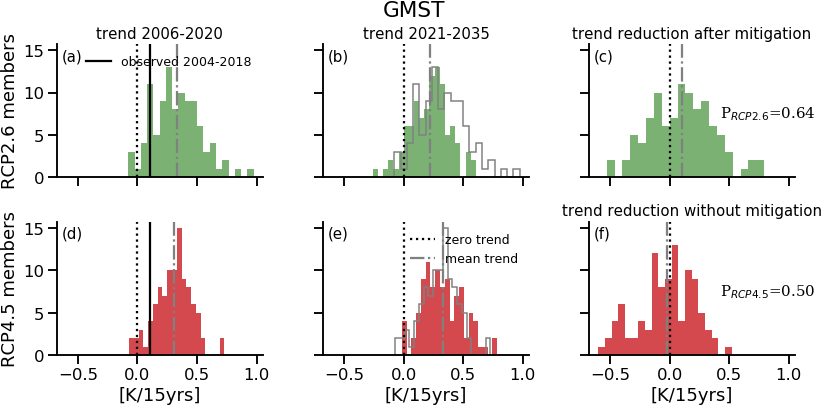

In [37]:
plot_Marotzke_2019_frequencies(gmst_cdo.rename({'tsurf':'GMST'}),sharex=True,unit='K', obs=obs_trend, obs_label='observed 2004-2018')
plt.savefig(paper_path+'FigureSI_15yr_trend_freq_GMST')

In [38]:
bootstrap=500
#boot_res = bootstrapping(gmst_cdo.load(),Marotzke_2019,print_res=False,output=True,combined=True,
#                         bootstrap=bootstrap, replacement=False)
#boot_res.to_dataframe().unstack().plot.hist(subplots=True,figsize=(5,10),bins=50)

In [39]:
#boot_res = bootstrapping(gmst_cdo.load(),Marotzke_2019,print_res=False,output=True,combined=True,
#                         bootstrap=bootstrap, replacement=True)
#boot_res.to_dataframe().unstack().plot.hist(subplots=True,figsize=(5,10),bins=50)

In [40]:
bootstrap=500
#P_gmst=over_trendlength(gmst_cdo,bootstrap=bootstrap,lower_end=1991,mintrend=3)
#P_gmst.to_netcdf('MPIESM_GE_P_GMST_bootstrap_'+str(bootstrap)+'.nc')

In [41]:
P_gmst = xr.open_dataset('MPIESM_GE_P_GMST_bootstrap_'+str(bootstrap)+'.nc')['tsurf']

         TDM
P           
P_S       27
P_N        3
P_NS       3
P_RCP26   26
P_RCP45    3 ignore P_RCP45 value


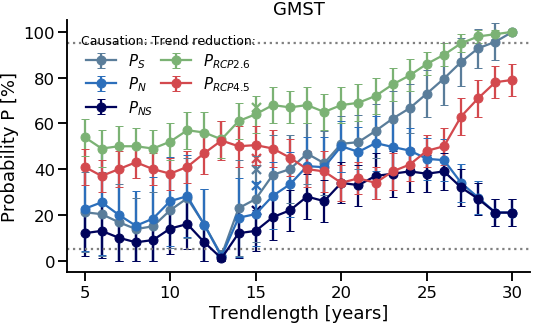

In [42]:
plot_P(P_gmst.sel(trendlength=slice(5,30)))
plt.xlim([4,31])
plt.xticks(np.arange(5,31,5))
sb.despine()
plt.savefig(paper_path+'FigureSI_Prob_GMST')

Figure Caption: Figure Caption: Probabilities of trend reduction and detection & attributation (blues) for GMST based on 100 uninitialized simulations. Errorbars are based on bootstrapping with 500 iterations at the 95% confidence level. For trends longer than 5 years, trend reductions in atmospheric CO$_2$ concentrations significantly differ.

Definitions:
- P_RCP26: Probability of trend reduction in GMST in scenario RCP2.6
- P_RCP45: Probability of trend reduction in GMST in scenario RCP4.5
- P_S: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient causation sense
- P_N: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a nessessary causation sense
- P_NS: Probability that shift from RCP4.5 to RCP2.6 causes the respective trend reduction in a sufficient and nessessary causation sense

## diagnosed co2atm

In [104]:
obs_co2 = PM.load.CO2_global_mean()
obs_co2 = PM.setup.yearmonmean(obs_co2)

In [112]:
for s in range(2004, #1990
               2015):
    obs_trend = float(linear_trend(obs_co2.sel(time=slice(s,s+4)).to_dataframe('obs').loc[:]).loc[0].values) * 5
    print(f'{s}-{s+4} trend: {obs_trend}')

2004-2008 trend: 9.930000000000119
2005-2009 trend: 9.397083333332933
2006-2010 trend: 9.429583333331186
2007-2011 trend: 9.660833333334113
2008-2012 trend: 9.75291666666725
2009-2013 trend: 10.847083333333234
2010-2014 trend: 10.919166666666417
2011-2015 trend: 11.294166666666182
2012-2016 trend: 12.512083333337634
2013-2017 trend: 12.678750000000283
2014-2018 trend: 13.055416666664037


In [111]:
#trend_late, trend_early, trendlength, P_S, P_N, P_NS,P_RCP26, P_RCP45=Marotzke_2019(cf_diagnosed,print_res=True,output=True,start=2016,end=2025)

In [ ]:
# quickcheck
v='co2_flux'
cf_diagnosed=diagnosed.rename({v:'combined'})['combined'].to_dataset().drop('member').rename({'member':'ext','time':'year','initialization':'member'})
cf_diagnosed['ext']=gmst_cdo.ext
max_trendlength=15
lower_end=2020-max_trendlength+1
P_co2_combined=over_trendlength(cf_diagnosed,bootstrap=10,varname=v,mintrend=3,lower_end=lower_end)
plot_P(P_co2_combined.sel(trendlength=slice(3,max_trendlength)),title='Diagnosed global atmospheric CO$_2$',loc='best')
plt.xlim([2,max_trendlength+1])
sb.despine()

co2_flx_ocean
         TDM
P           
P_S        3
P_N        6
P_NS       6
P_RCP26    3
P_RCP45    3 ignore P_RCP45 value


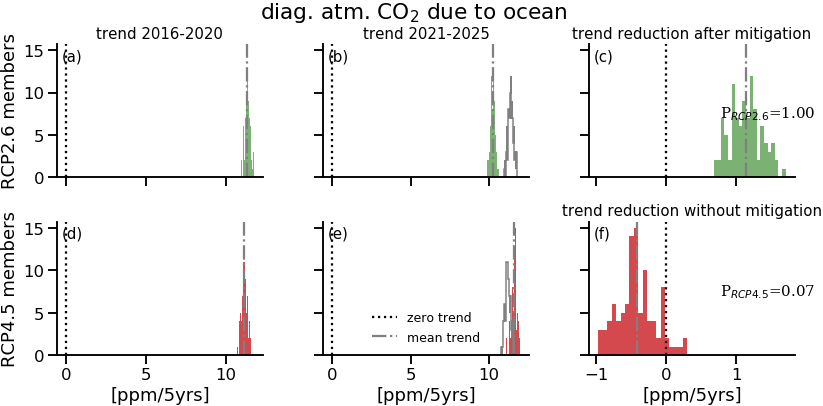

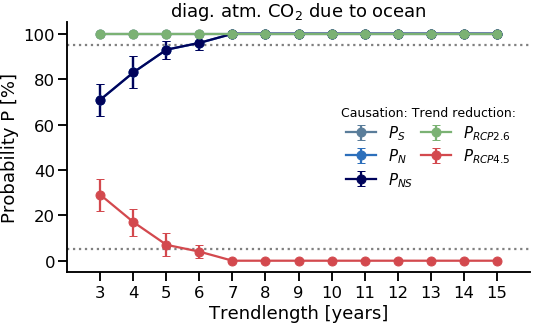

co2_flx_land
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value


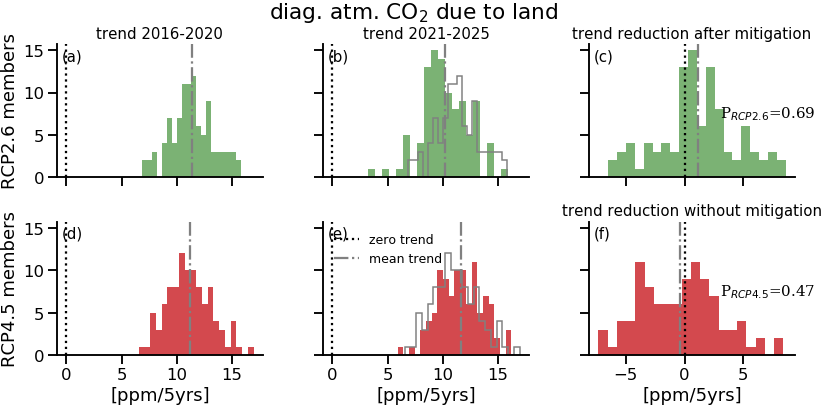

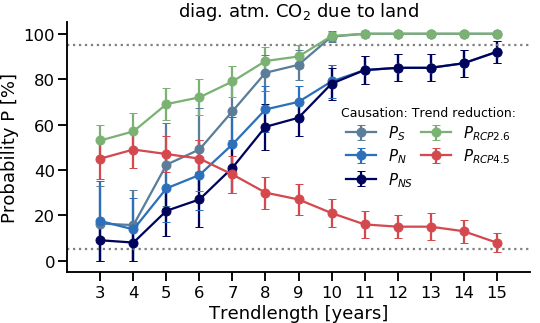

co2_flux
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value
         TDM
P           
P_S       10
P_N        3
P_NS       3
P_RCP26   10
P_RCP45    3 ignore P_RCP45 value


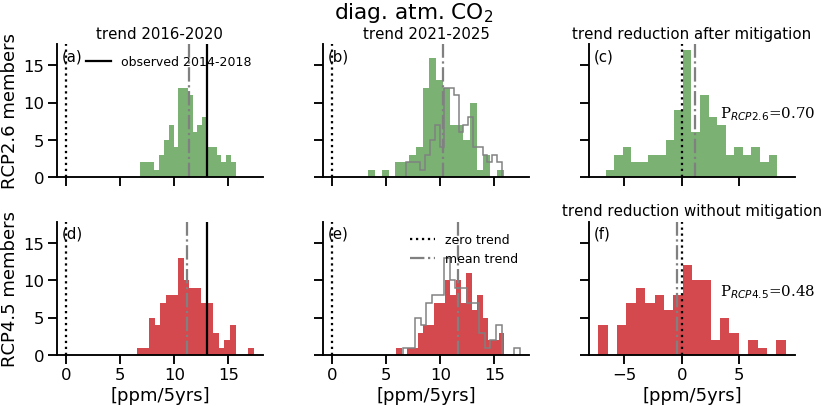

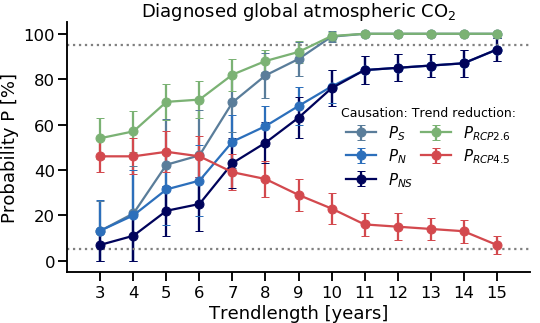

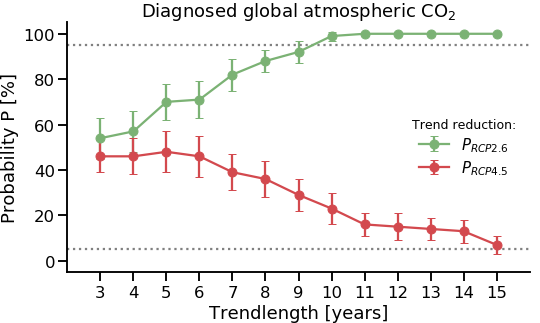

In [51]:
start=2016
end=2025

for v in list(diagnosed.data_vars)[::-1]:
    print(v)
    cf_diagnosed=diagnosed.rename({v:'combined'})['combined'].to_dataset().drop('member').rename({'member':'ext','time':'year','initialization':'member'})
    cf_diagnosed['ext']=gmst_cdo.ext
    
    if v == 'co2_flux':
        plot_Marotzke_2019_frequencies(cf_diagnosed.rename({'combined':'diag. atm. CO$_{2}$'}),
                                   start=start,end=end,unit='ppm',sharex='col',
                                   obs=obs_trend, obs_label='observed 2014-2018')
        plt.savefig(paper_path+'Figure2_5yr_trend_freq_diag_atm_CO2')
    else:
        plot_Marotzke_2019_frequencies(cf_diagnosed.rename({'combined':longname_diag[v]}),
                                   start=start,end=end,unit='ppm',sharex='col')                      
        plt.savefig(paper_path+'FigureSI_5yr_trend_freq_diag_atm_'+v)

    bootstrap=500
    max_trendlength=15
    lower_end=2020-max_trendlength+1
    #P_co2_combined=over_trendlength(cf_diagnosed,bootstrap=bootstrap,varname=v,mintrend=3,lower_end=lower_end)
    #P_co2_combined.to_netcdf(f'MPIESM_GE_P_diag_CO2_{v}_bootstrap_{bootstrap}.nc')
    P_co2_combined = xr.open_dataset(f'MPIESM_GE_P_diag_CO2_{v}_bootstrap_{bootstrap}.nc')['tsurf']
    
    if v == 'co2_flux':
        plot_P(P_co2_combined.sel(trendlength=slice(3,max_trendlength)),title='Diagnosed global atmospheric CO$_2$',loc='best')
        plt.xlim([2,max_trendlength+1])
        sb.despine()
        plt.savefig(paper_path+'Figure3_Prob_diag_atm_CO2')
        # of trend reduction
        plot_P(P_co2_combined.sel(trendlength=slice(3,max_trendlength)),title='Diagnosed global atmospheric CO$_2$',loc='best',causation=False)
        plt.xlim([2,max_trendlength+1])
        sb.despine()
        plt.savefig(paper_path+'Figure3_pre_Prob_diag_atm_CO2')
    else:
        plot_P(P_co2_combined.sel(trendlength=slice(3,max_trendlength)),title=longname_diag[v],loc='best')
        plt.xlim([2,max_trendlength+1])
        sb.despine()
        plt.savefig(paper_path+'FigureSI_Prob_diag_atm_'+v)
    plt.show()

In [52]:
dump=Marotzke_2019(cf_diagnosed,print_res=True,output=True,start=start,end=end)

Trends 2016 - 2020 2021 - 2025 Trendlength: 5

 events 
        combined            
ext       rcp26 rcp45 rcp85
member                     
1          7.47 -7.12 -3.45
2         -2.47 -2.24 -4.00
3          1.93 -5.56 -6.38
4          1.58 -1.09 -3.34
5          0.71 -2.41 -2.20

 event summary
 ext       rcp26  rcp45  rcp85
combined    0.7   0.48   0.33

P_S =
 combined    0.42
dtype: float64

P_N =
 combined    0.31
dtype: float64

P_NS =
 combined    0.22
dtype: float64


In [ ]:
#plot_Marotzke_2019(cf_diagnosed,unit='ppm',start=start,end=end)

## co2_flux

         TDM
P           
P_S        3
P_N        3
P_NS       3
P_RCP26   18
P_RCP45    3 ignore P_RCP45 value


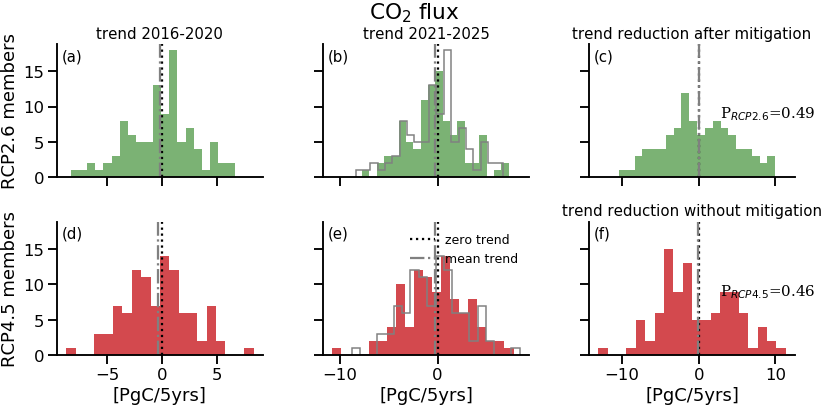

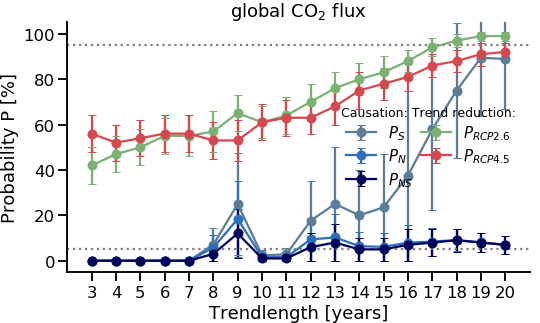

         TDM
P           
P_S        3
P_N        3
P_NS       3
P_RCP26    3
P_RCP45    3 ignore P_RCP45 value


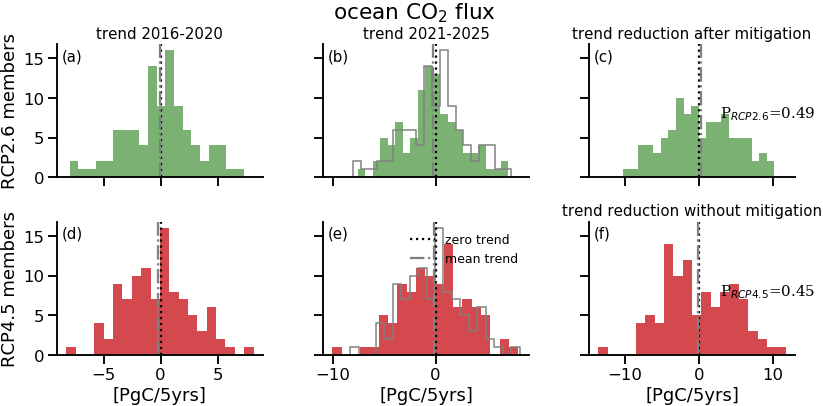

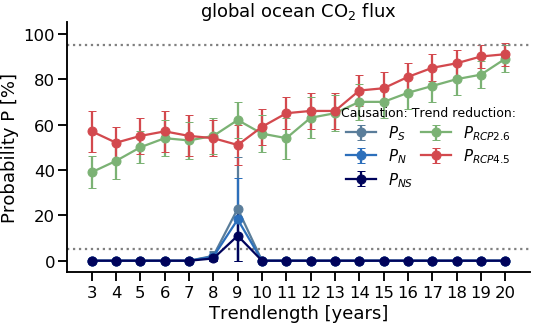

         TDM
P           
P_S       11
P_N        3
P_NS       3
P_RCP26   11
P_RCP45    3 ignore P_RCP45 value


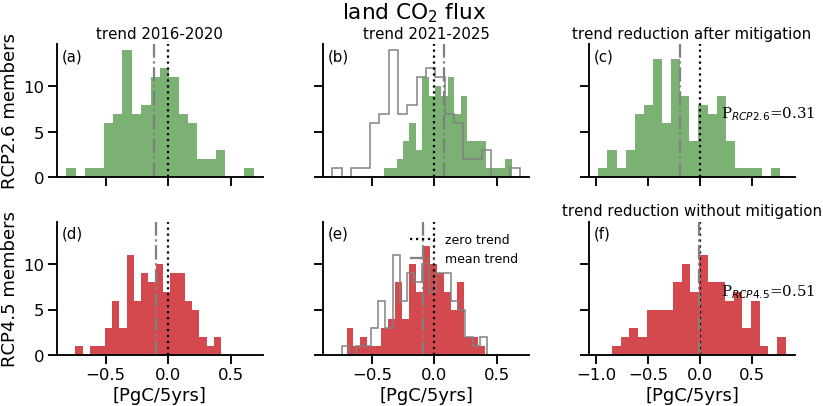

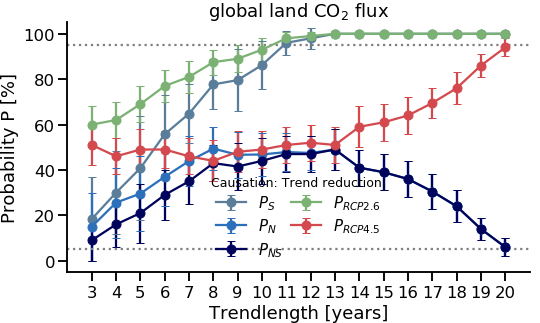

In [53]:
start=2016
end=2025
for v in cf.data_vars: #'co2_flux'
    cf_for_P = cf.drop('member').rename({'member':'ext','time':'year','initialization':'member'})[v].to_dataset(v)
    cf_for_P['ext']=gmst_cdo.ext

    plot_Marotzke_2019_frequencies(cf_for_P.rename({v:longname[v]}),
                                   start=start,end=end,unit='PgC',sharex='col')
    plt.savefig(paper_path+'FigureSI_5yr_trend_freq_'+v)

    bootstrap=500
    #P_co2_flux=over_trendlength(cf_for_P,bootstrap=bootstrap,varname=v,mintrend=3,lower_end=2001,event='stronger_trend')
    #P_co2_flux.to_netcdf(f'MPIESM_GE_P_{v}_bootstrap_{bootstrap}.nc')

    P_co2_flux = xr.open_dataset(f'MPIESM_GE_P_{v}_bootstrap_{bootstrap}.nc')['tsurf']

    plot_P(P_co2_flux.sel(trendlength=slice(3,20)),title='global '+longname[v])
    plt.xlim([2,21])
    sb.despine()
    plt.savefig(paper_path+'FigureSI_Prob_'+v)
    plt.show()

# compatible emissions

In [54]:
CE = ce.rename({'member':'ext','initialization':'member','time':'year'})
CE['ext']=gmst_cdo.ext
start = 2016
end = 2025

In [55]:
trend_late, trend_early, trendlength, P_S, P_N, P_NS,P_RCP26, P_RCP45 = Marotzke_2019(CE,
                                                                                      print_res=True,
                                                                                      output=True,
                                                                                      start=start,
                                                                                      end=end)

Trends 2016 - 2020 2021 - 2025 Trendlength: 5

 events 
        compatible_emissions            
ext                   rcp26 rcp45 rcp85
member                                 
1                      7.15  2.51  0.37
2                      5.68  3.79  3.08
3                     -2.96 -0.20  1.80
4                     -2.96 -2.00 -1.95
5                     -4.07  3.01  1.41

 event summary
 ext                   rcp26  rcp45  rcp85
compatible_emissions   0.56   0.53   0.47

P_S =
 compatible_emissions    0.06
dtype: float64

P_N =
 compatible_emissions    0.05
dtype: float64

P_NS =
 compatible_emissions    0.03
dtype: float64


In [56]:
#plot_Marotzke_2019(CE,unit='PgC',start=start,end=end)

In [57]:
#CE['compatible_emissions'].sel(year=slice(2005,2030)).isel(member=3).to_dataframe().unstack(0)['compatible_emissions'].plot()

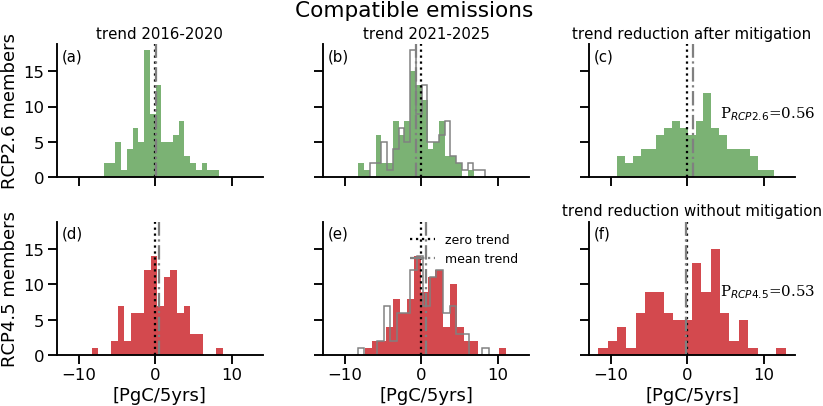

In [58]:
plot_Marotzke_2019_frequencies(CE.rename({'compatible_emissions':'Compatible emissions'}),sharex=True,unit='PgC',start=start,end=end)
plt.savefig(paper_path+'FigureSI_5yr_trend_freq_comp_emissions')

In [59]:
bootstrap=500
#P_CE=over_trendlength(CE,bootstrap=bootstrap,lower_end=2006,mintrend=3, varname='compatible_emissions')
#P_CE.to_netcdf('MPIESM_GE_P_CE_bootstrap_'+str(bootstrap)+'.nc')

In [60]:
P_CE = xr.open_dataset('MPIESM_GE_P_CE_bootstrap_'+str(bootstrap)+'.nc')['tsurf']

In [61]:
#P_CE.mean('bootstrap').to_dataframe().unstack().plot()

In [62]:
#CE.sel(year=slice(2000,2030),ext=['rcp26','rcp45']).mean('member').to_dataframe().unstack(0).plot(legend=False)

         TDM
P           
P_S       14
P_N        3
P_NS       3
P_RCP26   13
P_RCP45    3 ignore P_RCP45 value


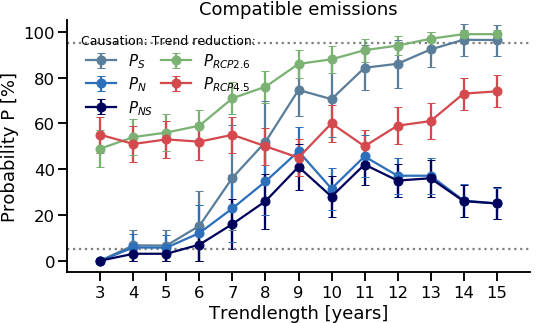

In [63]:
plot_P(P_CE.sel(trendlength=slice(3,15)),title='Compatible emissions')
plt.xlim([2,16])
sb.despine()
plt.savefig(paper_path+'FigureSI_Prob_comp_emissions')

# Predictability reduces uncertainty upto predictability horizon

GE is Perfect-model Predictability Simulation initialized in 2005
- 100 initializations
- 3 members

analysis script relies on https://github.com/bradyrx/climpred

In [116]:
from climpred.prediction import compute_perfect_model, compute_persistence
from climpred.bootstrap import _pvalue_from_distributions, _distribution_to_ci

In [140]:
def _pseudo_ens_GE(ds, ds2, dim='init'):
    """
    Shuffle ensemble members to uninitialize the data.
    """
    memberlist = []
    for m in ds.member.values:
        memberlist.append(ds.sel(member=m))

    shuffledlist = []
    for ds_m in memberlist:
        shuffledlist.append(shuffle(ds_m, dim=dim))

    shuffled = xr.concat(shuffledlist, dim='member')
    return shuffled

In [154]:
from climpred.bootstrap import bootstrap_compute
from PMMPIESM.predictability import shuffle
def bootstrap_perfect_model_GE(ds,
    control,
    metric='pearson_r',
    comparison='m2e',
    dim=None,
    sig=95,
    bootstrap=5,
    pers_sig=None):
    """Use bootstrap_compute with different resampling function for large ensembles."""
    if dim is None:
        dim = ['init', 'member']
    return bootstrap_compute(
        ds,
        control,
        hist=None,
        metric=metric,
        comparison=comparison,
        dim=dim,
        sig=sig,
        bootstrap=bootstrap,
        pers_sig=pers_sig,
        compute=compute_perfect_model,
        resample_uninit=_pseudo_ens_GE
    )

In [143]:
bootstrap=50
def compute_uninit_skill(ds,bootstrap=bootstrap,metric='pearson_r',comparison='m2e',sig=95,**kwargs):
    uninit = []
    for _ in range(bootstrap):
        uninit_ds = _pseudo_ens_GE(ds, dim='init')
        # compute uninit skill
        uninit.append(
            compute_perfect_model(
                uninit_ds,
                metric=metric,
                comparison=comparison,
                **kwargs))
    uninit = xr.concat(uninit, dim='bootstrap').mean('bootstrap')
    return uninit

In [220]:
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

def plot_skills(skills,title,stitle,metric,ax=None,savefig=True):
    if ax is None:
        fig,ax = plt.subplots(figsize=(6.5,4))
    plot_bootstrapped_skill_over_leadyear(skills.isel(lead=slice(0,11)),sig,plot_persistence=False,ax=ax)
    plt.title(title+' predictability')
    if metric == 'rmse':
        plt.ylabel(metric.upper()+' ['+units[v]+']')
    elif metric == 'pearson_r':
        plt.ylabel('ACC')
        plt.ylim(min(-.05,skills.sel(kind='uninit',results='low_ci').min()),1)
    else:
        plt.ylabel(metric+' ')
        plt.ylim([0, skills.sel(results='high_ci').max()*1.1])
    plt.xticks(np.arange(0,11))
    filename='_'.join(['skill',stitle,metric])
    plt.tight_layout()
    plt.legend(fontsize='x-small',frameon=False,loc='best')
    sb.despine(fig)
    if savefig:
        print('saved as',filename)
        plt.savefig(filename)

In [146]:
#uninit_ds = _pseudo_ens_GE(ds, dim='init')

## GMST

In [246]:
metrics=['pearson_r','rmse']

In [247]:
v='tsurf'
comparison='m2e'
sig=95
title=longname[v]
stitle='GMST'

In [248]:
bootstrap=5000

In [249]:
gmst['initialization']=np.arange(1,1+gmst.initialization.size)

start=2005
end=2025
ds=gmst['tsurf'].sel(time=slice(start,end)).rename({'time':'lead','initialization':'init'})
ds['lead']=np.arange(end-start+1)

[279.42028809] [279.9249939]
[25 55 79 80 93]


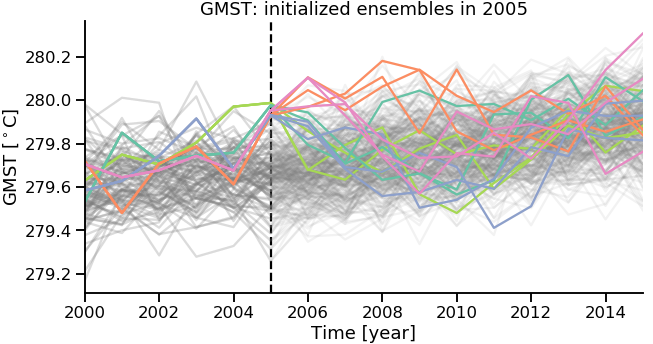

In [250]:
pos_inits, neg_inits = get_inits(gmst)
print(pos_inits)

plot_inits(gmst,pos_inits=pos_inits)
plt.title(title+': initialized ensembles in 2005')
plt.ylabel(f'{longname[v]} [{units[v]}]')
filename='_'.join(['initialized',title])
plt.xlabel('Time [year]')
sb.despine()
#plt.savefig(filename)

In [251]:
ds=ds.isel(lead=slice(1,11))

In [252]:
fref = ds.rename({'init':'time'}).isel(lead=0,member=0)
del fref['member']
del fref['lead']
metric='pearson_r'

saved as skill_GMST_pearson_r
saved as skill_GMST_rmse


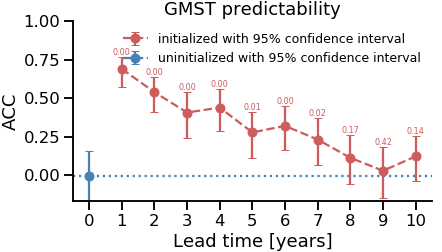

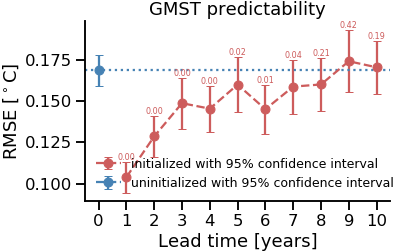

In [253]:
for metric in metrics:
    skills = bootstrap_perfect_model_GE(ds,fref,comparison=comparison,bootstrap=bootstrap,metric=metric)
    plot_skills(skills,title,stitle,metric)

## diagnosed atm. CO$_2$

In [254]:
start=2005
end=2015

In [255]:
diagnosed = diagnosed_new.transpose(*['time','initialization','member']).rename(
    {'co2_flux':'combined','co2_flx_ocean':'ocean','co2_flx_land':'land'})

In [256]:
v='combined'
title=longname[v]
stitle='diag_atm_CO2'

[377.10013123] [380.782757]


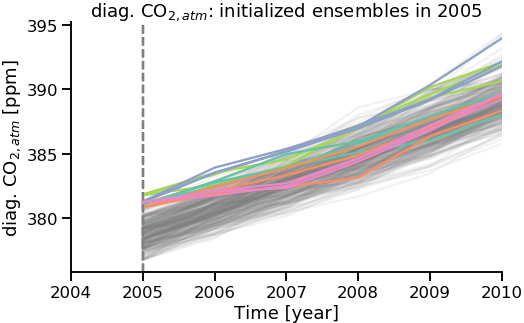

In [257]:
pos_inits, neg_inits = get_inits(diagnosed[v].to_dataset(),psig=.95)

end=2010
fig,ax=plt.subplots(figsize=(8,5))
plot_inits(diagnosed,var=v,pos_inits=pos_inits,end=end,ax=ax)
plt.title(title+': initialized ensembles in 2005')
filename='_'.join(['initialized',stitle])
i=ax.axvline(x=2005,ls='--',c='gray')
plt.xlabel('Time [year]')
plt.xlim([2004,end])
plt.ylabel(f'{longname[v]} [{units[v]}]')
plt.title('diag. CO$_{2,atm}$: initialized ensembles in 2005')
plt.tight_layout()
sb.despine()
#plt.savefig(filename)
end=2015

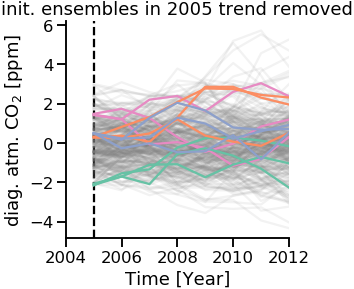

In [258]:
fig,ax=plt.subplots(figsize=(4,4))
plot_inits(diagnosed-diagnosed.mean('initialization'),var=v,pos_inits=[1,2,3,4],start=2004,end=2012,ax=ax)
plt.title('init. ensembles in 2005 trend removed')
plt.ylabel(f'diag. atm. CO$_2$ [{unit[v]}]')
plt.xlabel('Time [Year]')
filename='_'.join(['initialized_rm_trend',stitle])
sb.despine()
#plt.savefig(filename+'.png')

saved as skill_diag_atm_CO2_pearson_r
saved as skill_diag_atm_CO2_rmse
saved as skill_diag_atm_CO2_land_pearson_r
saved as skill_diag_atm_CO2_land_rmse
saved as skill_diag_atm_CO2_ocean_pearson_r
saved as skill_diag_atm_CO2_ocean_rmse


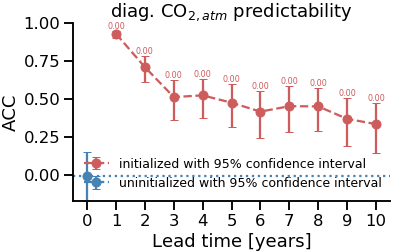

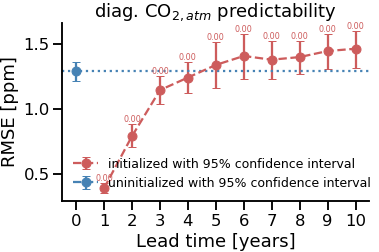

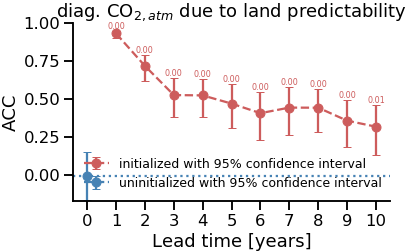

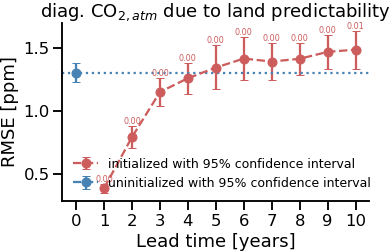

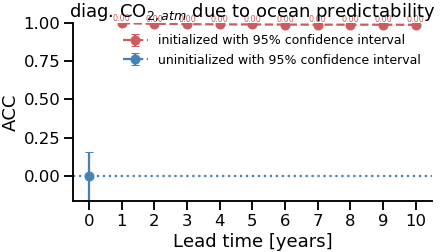

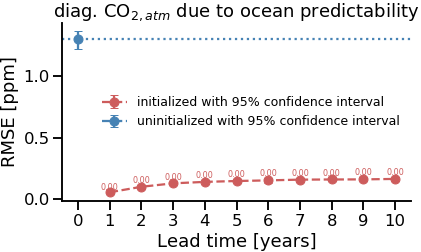

In [260]:
for v in diagnosed.data_vars:
    title=longname[v]
    if v == 'combined':
        stitle='diag_atm_CO2'
    else:
        stitle='diag_atm_CO2'+'_'+v
    add=0
    ds = diagnosed[v].sel(time=slice(start-add,end)).rename({'time':'lead','initialization':'init'})

    ds['lead']=np.arange(end-start+add+1)
    
    removetrend=True #False
    if removetrend:
        remove_trend = co2atm_forcing['co2atm'].sel(time=slice(start-add,end)).rename({'time':'lead'})
        remove_trend['lead']=np.arange(end-start+1)
        ds = ds-remove_trend

    ds['lead'] = np.arange(ds.lead.size)

    ds=ds.isel(lead=slice(1,11))
    
    # create fake reference as input
    fref = ds.rename({'init':'time'}).isel(lead=0,member=0)
    del fref['member']
    del fref['lead']

    for metric in metrics:
        skills = bootstrap_perfect_model_GE(ds, fref,comparison=comparison,bootstrap=bootstrap,metric=metric)
        plot_skills(skills,title,stitle,metric)

## co2_flux

In [261]:
start=2005

saved as skill_co2_flux_pearson_r
saved as skill_co2_flux_rmse
saved as skill_co2_flx_land_pearson_r
saved as skill_co2_flx_land_rmse
saved as skill_co2_flx_ocean_pearson_r
saved as skill_co2_flx_ocean_rmse


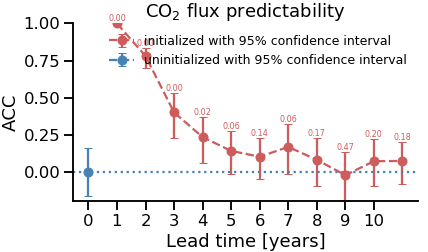

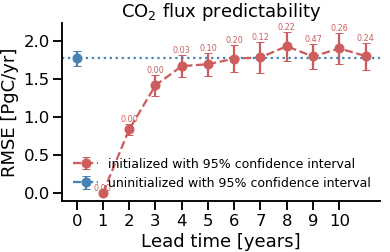

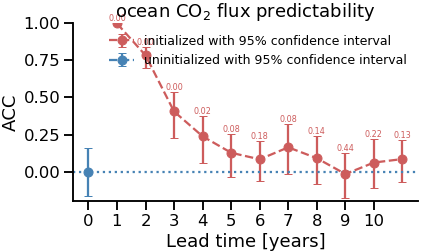

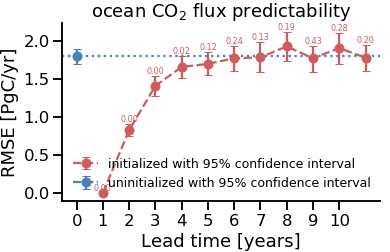

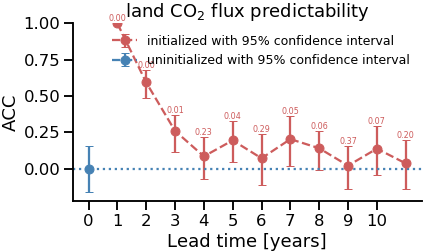

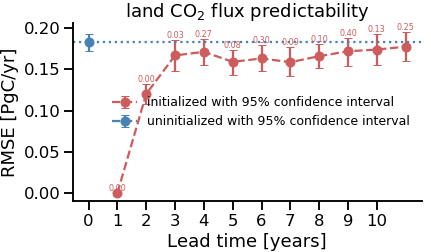

In [262]:
for v in cf.data_vars:
    title=longname[v]
    stitle=v

    ds = cf[v].sel(time=slice(start,end)).rename({'time':'lead','initialization':'init'})
    ds['lead']=np.arange(end-start+1)

    fref = ds.rename({'init':'time'}).isel(lead=0,member=0)
    del fref['member']
    del fref['lead']

    for metric in metrics:
        skills = bootstrap_perfect_model_GE(ds,fref,comparison=comparison,bootstrap=bootstrap,metric=metric)
        plot_skills(skills,title,stitle,metric)

## compatible emissions

In [265]:
start=2005
end=2025
ds=ce.sel(time=slice(start,end)).rename({'time':'lead','initialization':'init'})
ds['lead']=np.arange(end-start+1)

saved as skill_comp_emissions_pearson_r
saved as skill_comp_emissions_rmse


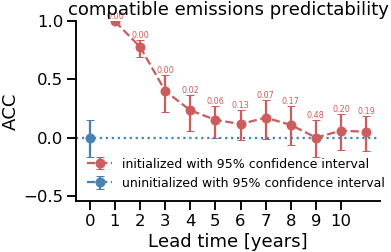

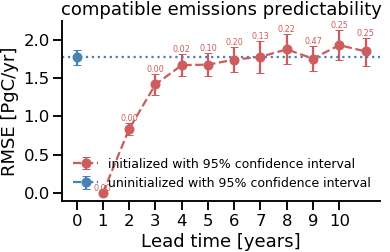

In [272]:
title='compatible emissions'
stitle='comp_emissions'

fref = ds.rename({'init':'time'}).isel(lead=0,member=0)
del fref['member']
del fref['lead']

for metric in metrics:
    skills = bootstrap_perfect_model_GE(ds,fref,comparison=comparison,bootstrap=bootstrap,metric=metric)
    plot_skills(skills,title,stitle,metric)

# predicting trend increases

In [345]:
try:
    ds=diagnosed['co2_flux']
except:
    ds=diagnosed['combined']
ds.name = 'co2'
ds=ds-ds.mean('initialization')

In [346]:
ds=ds.rename({'initialization':'init'})

In [347]:
from esm_analysis.stats import linear_regression
from xskillscore import brier_score, threshold_brier_score, crps_ensemble, crps_gaussian
from climpred.bootstrap import bootstrap_perfect_model

In [348]:
def create_trends_for_trendlength(ds,min_trendlength=2,max_trendlength=20):
    trends=[]
    for trendlength in range(min_trendlength,max_trendlength):
        trend = linear_regression(ds.isel(time=slice(None,trendlength)))['slope']
        trends.append(trend)
    trends=xr.concat(trends,'trendlength')
    trends['trendlength']=range(min_trendlength,max_trendlength)
    return trends

In [349]:
trends = create_trends_for_trendlength(ds)

In [350]:
def pos(ds):
    return ds > 0

In [351]:
def init_metric(trends, bootstrap=10, metric='crpss', comparison='m2m',**kwargs):
    b_res=[]
    for i in trange(bootstrap):
        smp_inits = np.random.choice(trends.init.values, trends.init.size)
        smp_trends = trends.sel(init=smp_inits)
        smp_trends['init'] = np.arange(1,1+smp_trends.init.size)
        res = compute_perfect_model(smp_trends,smp_trends,metric=metric,comparison=comparison, dim='member',**kwargs)
        b_res.append(res)
    res = xr.concat(b_res,'bootstrap')
    return res


def uninit_metric(trends, bootstrap=10,metric='crpss', comparison='m2m',**kwargs):
    res = []
    for i in trange(bootstrap):
        uninit_ds = _pseudo_ens_GE(trends, dim='init')
        c_uninit = compute_perfect_model(uninit_ds,uninit_ds,metric=metric,comparison=comparison, dim='member',**kwargs)
        res.append(c_uninit)
    c_uninit = xr.concat(res,'bootstrap')
    return c_uninit

In [352]:
def plot_score(res,uninit_res,metric_str):
    uninit_res.mean(['init','bootstrap']).plot(label='uninit',c='royalblue',marker='o')
    uninit_res.mean(['init']).quantile(.95,'bootstrap').plot(label='uninit CI',c='royalblue',alpha=.5)
    uninit_res.mean(['init']).quantile(.05,'bootstrap').plot(c='royalblue',alpha=.5)
    res.mean(['init','bootstrap']).plot(color='indianred',label='initialized',marker='o')
    res.mean(['init']).quantile(.95,'bootstrap').plot(color='indianred',alpha=.5,label='initialized CI')
    res.mean(['init']).quantile(.05,'bootstrap').plot(color='indianred',alpha=.5)
    plt.legend(frameon=False,fontsize=12)
    plt.ylim([min(res.min(),uninit_res.min()),max(res.max(),uninit_res.max())])
    plt.ylabel(metric_str)
    plt.title('predictability of positive atm. CO$_2$ trend')
    sb.despine()
    plt.tight_layout()
    return plt

In [60]:
bootstrap=100
for metric in ['crpss', 'brier_score']:
    c_uninit = uninit_metric(trends,metric=metric,bootstrap=bootstrap,func=pos)
    c_init = init_metric(trends,metric=metric,bootstrap=bootstrap,func=pos)
    metric_str=metric.upper().replace('_',' ')
    plot_score(c_init,c_uninit,metric_str=metric_str)
    plt.savefig(metric_str+'_CO2_trend',bbox_inches='tight')

# analog prediction of atm CO2

In [122]:
nino3=PMMPIESM.load.NINO3().groupby('time.year').mean().rename({'year':'time'})

Text(0.5, 1.0, 'NINO3 predicts next years CO2 growth rate')

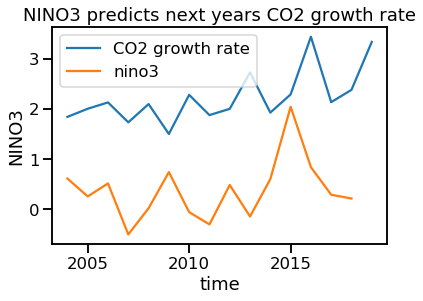

In [123]:
GMGR.to_xarray()['GM'].sel(time=slice(2004,None)).plot(label='CO2 growth rate')
nino3.sel(time=slice(2004,None)).plot(label='nino3')
plt.legend()
plt.title('NINO3 predicts next years CO2 growth rate')

In [124]:
from esm_analysis.stats import corr
c = [corr(nino3.sel(time=slice(1981,2018)),GMGR.to_xarray()['GM'].sel(time=slice(1981,2018)),'time',lag=i).values.astype('float') for i in range(4)]

In [125]:
c

[array(-0.12679374), array(0.44745963), array(-0.00156553), array(-0.26771825)]

In [126]:
# find 2005 init conditions, so 2004 nino

In [127]:
nino3.sel(time=2004)

<xarray.DataArray 'NINO3' ()>
array(0.615636)
Coordinates:
    time     int64 2004

In [26]:
GM_nino = xr.open_mfdataset('/Users/aaron.spring/mistral_m300524/post/mpiom/161103_ENSO/output/lkm0???_sst_anomaly_standardized_runavg_1855_2005_3.nc', concat_dim='member')

In [27]:
GM_nino=GM_nino['sst'].squeeze()
del GM_nino['lon']
del GM_nino['lat']
del GM_nino['depth']
GM_nino['member']=np.arange(1,101)

In [28]:
GM_nino=GM_nino.groupby('time.year').mean('time').rename({'year':'time'}).sel(time=slice(2000, None)).compute()

In [135]:
s=np.abs((GM_nino.sel(time=2004)-.61))
s=s.sortby(s)

In [133]:
obs_init_member = list(s.isel(member=slice(0,5)).member.values)
obs_init_member

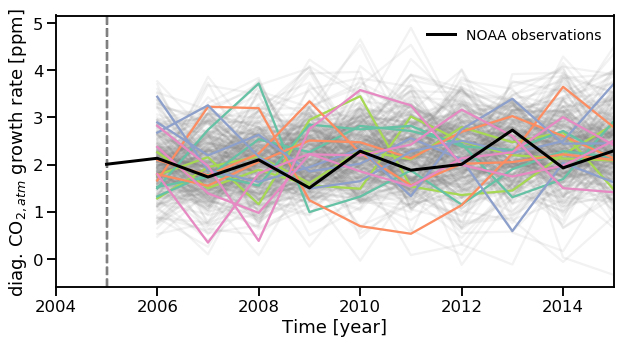

In [134]:
plot_inits(diagnosed.diff('time'),var=v,pos_inits=obs_init_member)
ax=plt.gca()
plt.title(title+': initialized ensembles in 2005')
filename='_'.join(['initialized',stitle,'growth_rate'])
i=ax.axvline(x=2005,ls='--',c='gray')
GM_ts = PMMPIESM.load.CO2_global_mean().groupby('time.year').mean('time').rename({'year':'time'})
m=(GM_ts.diff('time')).sel(time=slice(2005,2019)).plot(
    ax=ax,c='k',lw=3)
ax.legend((m),['NOAA observations'],fontsize=14, frameon=False)
#plt.legend((m,i),('ensemble mean','initializations'),fontsize=14, frameon=False)
plt.xlabel('Time [year]')
plt.xlim([2004,2015])
plt.ylabel(f'{longname[v]} growth rate [{units[v]}]')
plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0.05)

In [124]:
w=diagnosed['combined'].rename({'initialization':'init'}).sel(time=slice(2005,2015))

In [125]:
from xskillscore import rmse, pearson_r

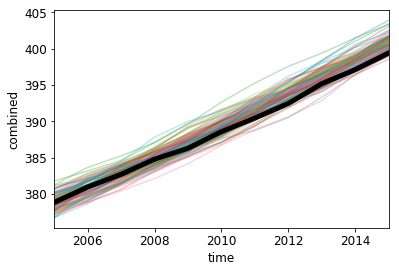

In [141]:
w.mean('member').to_dataframe().unstack().plot(ax=plt.gca(),legend=False,alpha=.3)
GM_ts.sel(time=slice(2005,2015)).plot(c='k',lw=5)

In [89]:
import intake
import PMMPIESM
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PMMPIESM.load import NINO3, PDO, CO2_global_mean, CO2_Mauna_Loa
from PMMPIESM.variability import standardize

In [2]:
cat = intake.open_catalog(PMMPIESM.setup.home_origin+'pymistral/intake/mBGC_obs.yml')

In [166]:
co2_gm_obs = CO2_Mauna_Loa()#CO2_global_mean()

/Users/aaron.spring/anaconda3/envs/xr/lib/python3.7/site-packages/PMMPIESM-0.1-py3.7.egg/PMMPIESM/load.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['year month', 'decimal date', 'average', 'interpolated', 'trend', 'days', '6', '7', '8', '9', '10'])


In [145]:
nino3 = NINO3(month=None)

/Users/aaron.spring/anaconda3/envs/xr/lib/python3.7/site-packages/PMMPIESM-0.1-py3.7.egg/PMMPIESM/load.py:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  names=['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], index_col=['Year'])


In [146]:
nino3.sel(time='2005-12')

<xarray.DataArray 'NINO3' (time: 1)>
array([-0.842182])
Coordinates:
  * time     (time) datetime64[ns] 2005-12-31
    month    (time) int64 12

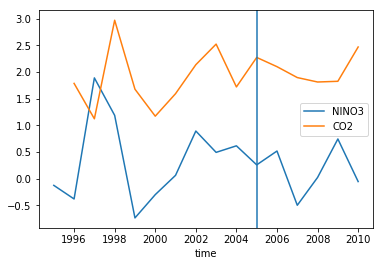

In [167]:
nino3.sel(time=slice('1995','2010')).groupby('time.year').mean('time').rename({'year':'time'}).plot(label='NINO3')
co2_gm_obs.sel(time=slice('1995','2010')).groupby('time.year').mean('time').rename({'year':'time'}).diff('time').plot(label='CO2')
plt.axvline(x=2005)
plt.legend()

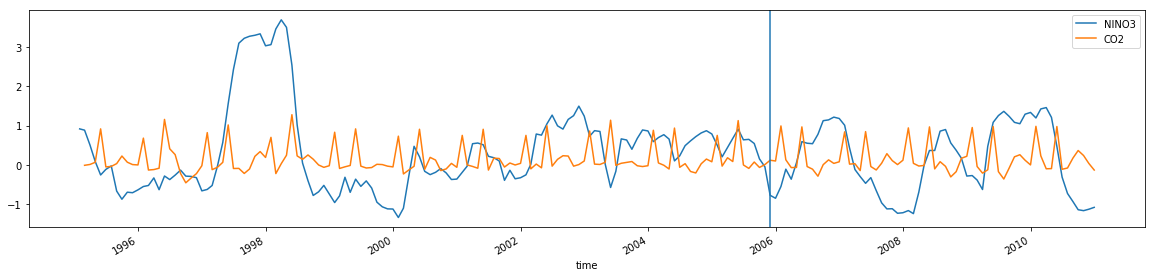

In [164]:
nino3.sel(time=slice('1995','2010')).plot(label='NINO3',figsize=(20,4))
(co2_gm_obs.groupby('time.month')-co2_gm_obs.groupby('time.month').mean('time')).sel(time=slice('1995','2010')).diff('time').plot(label='CO2')
plt.axvline(x='2005-12')
plt.legend()

# model eval

In [444]:
co2_growth_rate = pd.read_csv('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_gr_mlo.txt',header=59, sep='   ')

In [445]:
co2_growth_rate.columns = ['Year', '1','Ann inc', '2', 'unc']

In [446]:
co2_growth_rate=co2_growth_rate[['Year','Ann inc', 'unc']].set_index('Year')

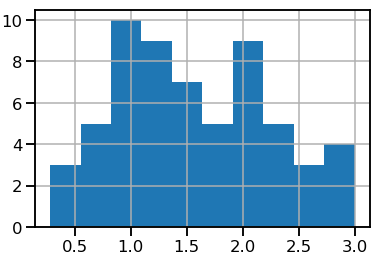

In [447]:
co2_growth_rate['Ann inc'].hist()

In [448]:
co2_growth_rate['Ann inc'].describe()

count    60.000000
mean      1.577500
std       0.672296
min       0.280000
25%       1.037500
50%       1.525000
75%       2.040000
max       3.000000
Name: Ann inc, dtype: float64

In [451]:
model = (cf_internal_variability['co2_flux'].sel(time=slice(1958,2018)).sel(member='rcp45',drop=True).cumsum('time')/2.13
         +co2atm_forcing.sel(time=slice(1958,2018)).isel(member=0,drop=True)).diff('time').to_dataframe()

In [452]:
model.describe().round(2)

co2atm
count  6000.00
mean      1.54
std       0.86
min      -1.34
25%       0.94
50%       1.54
75%       2.12
max       5.03

In [453]:
comparison = pd.merge(model.describe(),co2_growth_rate['Ann inc'].describe(),left_index=True,right_index=True).round(2)
comparison.columns = ['modelled','observed']
comparison

modelled  observed
count   6000.00     60.00
mean       1.54      1.58
std        0.86      0.67
min       -1.34      0.28
25%        0.94      1.04
50%        1.54      1.52
75%        2.12      2.04
max        5.03      3.00

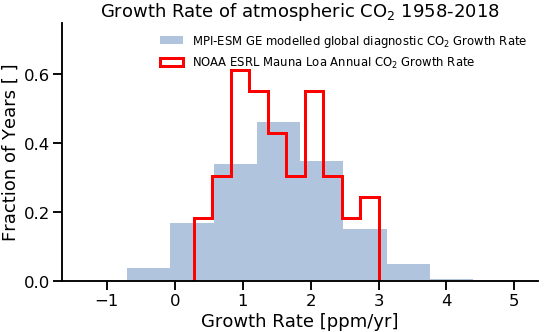

In [467]:
alpha=1
density=True
fig,ax=plt.subplots(figsize=(8,5))
model.hist(ax=ax,density=True, color='lightsteelblue',label='MPI-ESM GE modelled global diagnostic CO$_2$ Growth Rate',alpha=alpha)
co2_growth_rate['Ann inc'].hist(color='red',lw=3,histtype='step',ax=ax,density=True,label='NOAA ESRL Mauna Loa Annual CO$_2$ Growth Rate',alpha=alpha)
plt.legend(frameon=False, fontsize='small')
plt.ylabel('Fraction of Years [ ]')
plt.xlabel('Growth Rate [ppm/yr]')
plt.title('Growth Rate of atmospheric CO$_2$ 1958-2018')
plt.tight_layout()
plt.ylim([0,.75])
sb.despine()
ax.grid(False)
plt.savefig(paper_path+'FigureSI_Growth_Rate_distribution')

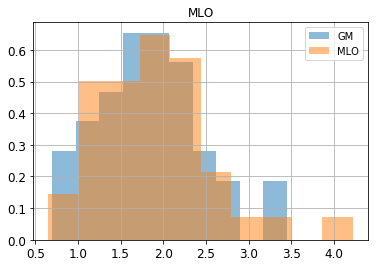

In [20]:
GM.hist(density=True,label='GM',alpha=.5)
MLO.hist(density=True,ax=plt.gca(),label='MLO',alpha=.5)
sb.despine()
plt.legend()

In [26]:
pd.merge(MLO.describe(),GM.describe(),left_index=True,right_index=True).round(2)

MLO     GM
count  39.00  39.00
mean    1.90   1.84
std     0.68   0.62
min     0.65   0.70
25%     1.51   1.48
50%     1.79   1.84
75%     2.19   2.14
max     4.22   3.44

# compatible emission

In [88]:
ds=[]
for r in cf.member.values:
    if r == 'rcp26':
        r='rcp3pd'
    r=r.upper()
    #http://www.pik-potsdam.de/~mmalte/rcps/
    link = f'http://www.pik-potsdam.de/~mmalte/rcps/data/{r}_EMISSIONS.xls'
    print(r,link)

    e=pd.read_excel(link,sheet_name=f'{r}_EMISSIONS',skiprows=35,header=2)
    e=e.set_index(e.columns[0])
    e.index.name = 'Year'
    ds.append(e[['FossilCO2','OtherCO2']].to_xarray())

ds = xr.concat(ds,'member')

ds = ds.sel(Year=slice(1850,2100)).rename({'Year':'time'})
ds['member'] = cf.member

ds['IAM_emissions'] = ds['FossilCO2']+ds['OtherCO2']

ds = ds['IAM_emissions']

RCP3PD http://www.pik-potsdam.de/~mmalte/rcps/data/RCP3PD_EMISSIONS.xls
RCP45 http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_EMISSIONS.xls
RCP85 http://www.pik-potsdam.de/~mmalte/rcps/data/RCP85_EMISSIONS.xls


In [89]:
ds.to_dataset('IAM_emissions').to_netcdf('IAM_emissions.nc')

In [ ]:
ds = xr.open_dataset('IAM_emissions.nc')

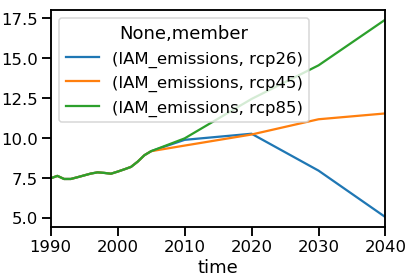

In [90]:
ds.sel(time=slice(1990,2040)).to_dataframe().unstack(0).plot()

In [91]:
def compatible_emissions(co2_flux,co2atm_forcing):
    ce = co2atm_forcing.diff('time')*2.12-co2_flux
    ce.name = 'compatible_emissions'
    return ce

In [92]:
ce = compatible_emissions(cf['co2_flux'],co2atm_forcing['co2atm'])

In [93]:
#ce.to_dataset().to_netcdf('compatible_emissions.nc')

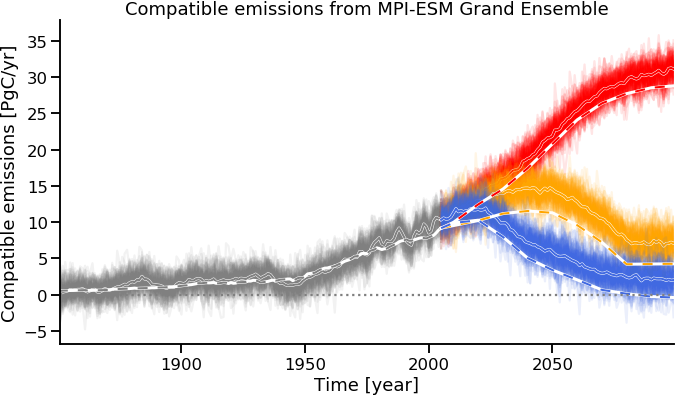

In [95]:
plot_IAM_emissions=True
fig,ax=plt.subplots(figsize=(10,6))
# hist
alpha=.1
c='gray'
ce.isel(member=0).sel(time=slice(None,2005)).to_dataframe().unstack()['compatible_emissions'].plot(ax=ax,legend=False, color=c, alpha=alpha)
ce.isel(member=0).sel(time=slice(None,2005)).mean('initialization').plot(ax=ax,color='w',lw=3)
ce.isel(member=0).sel(time=slice(None,2005)).mean('initialization').plot(ax=ax,color=c,lw=2)
# rcps
colors=['royalblue','orange','red'][::-1]
for i,m in enumerate(cf.member.values[::-1]):
    c=colors[i]
    ce.sel(member=m).sel(time=slice(2005,None)).to_dataframe().unstack()['compatible_emissions'].plot(ax=ax,legend=False, color=c, alpha=alpha)
    ce.sel(member=m).sel(time=slice(2005,None)).mean('initialization').plot(ax=ax,color='w',lw=3)
    ce.sel(member=m).sel(time=slice(2005,None)).mean('initialization').plot(ax=ax,color=c,lw=2)

if plot_IAM_emissions:
    # IAM emissions
    ls=(0, (5, 5))
    ds.isel(member=0).sel(time=slice(None,2005)).plot(ax=ax,color='white',lw=3)
    ds.isel(member=0).sel(time=slice(None,2005)).plot(ax=ax,color='gray',lw=2,ls=ls)
    for i,m in enumerate(cf.member.values[::-1]):
        c=colors[i]
        ds.sel(member=m).sel(time=slice(2005,None)).plot(ax=ax,color='white',lw=3)
        ds.sel(member=m).sel(time=slice(2005,None)).plot(ax=ax,color=c,lw=2,ls=ls)

# fig aestetics
ax.axhline(y=0,ls=':',c='gray')
ax.set_ylabel('Compatible emissions [PgC/yr]')
ax.set_xlabel('Time [year]')
plt.title('Compatible emissions from MPI-ESM Grand Ensemble')
plt.tight_layout()
sb.despine()
plt.savefig(paper_path+'FigureSI_MPIESM_GE_Compatible_emissions')
plt.savefig(paper_path+'FigureSI_MPIESM_GE_Compatible_emissions.png')